# Анализ датасета авиационных инцидентов с использованием машинного обучения

## Цель проекта
Провести полный цикл анализа данных и обучения моделей машинного обучения на датасете авиационных инцидентов.

## Структура проекта
1. Загрузка и первичный анализ данных
2. Обработка пропущенных значений
3. Изменение структуры данных
4. Кодирование категориальных признаков
5. Визуализация данных
6. Отбор признаков
7. Проверка сбалансированности классов
8. Разбиение на train/test и нормализация
9. Обучение моделей машинного обучения
10. Оценка и оптимизация моделей


In [31]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

# Библиотеки для машинного обучения
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, classification_report, 
                             confusion_matrix, roc_curve, auc)
from sklearn.feature_selection import (VarianceThreshold, SelectKBest, 
                                       f_classif, RFE, SelectFromModel)

# CatBoost
try:
    from catboost import CatBoostClassifier
    CATBOOST_AVAILABLE = True
except ImportError:
    print("CatBoost не установлен. Установите: pip install catboost")
    CATBOOST_AVAILABLE = False

# Нейронные сети
try:
    from tensorflow import keras
    from tensorflow.keras import layers
    TENSORFLOW_AVAILABLE = True
except ImportError:
    print("TensorFlow не установлен. Установите: pip install tensorflow")
    TENSORFLOW_AVAILABLE = False

# Настройка отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Библиотеки успешно импортированы!")


Библиотеки успешно импортированы!


## 1. Загрузка и первичный анализ данных


In [32]:
# Загрузка датасета
file_path = '/Users/nickolay/Downloads/Aircraft_Incident_Dataset.csv'
df = pd.read_csv(file_path, encoding='utf-8')

# Проверка корректности считывания файла
print("=" * 80)
print("1. ПРОВЕРКА КОРРЕКТНОСТИ СЧИТЫВАНИЯ ФАЙЛА")
print("=" * 80)
print(f"\nРазмер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов")
print(f"\nПервые 5 строк:")
print(df.head())
print(f"\nПоследние 5 строк:")
print(df.tail())


1. ПРОВЕРКА КОРРЕКТНОСТИ СЧИТЫВАНИЯ ФАЙЛА

Размер датасета: 23519 строк, 23 столбцов

Первые 5 строк:
  Incident_Date                        Aircaft_Model Aircaft_Registration  \
0   03-JAN-2022  British Aerospace 4121 Jetstream 41               ZS-NRJ   
1   04-JAN-2022  British Aerospace 3101 Jetstream 31               HR-AYY   
2   05-JAN-2022                       Boeing 737-4H6               EP-CAP   
3   08-JAN-2022                  Tupolev Tu-204-100C             RA-64032   
4   12-JAN-2022        Beechcraft 200 Super King Air                  NaN   

           Aircaft_Operator                    Aircaft_Nature  \
0                SA Airlink  Domestic Non Scheduled Passenger   
1                    LANHSA      Domestic Scheduled Passenger   
2          Caspian Airlines      Domestic Scheduled Passenger   
3  Cainiao, opb Aviastar-TU                             Cargo   
4                   private                    Illegal Flight   

                                   Incident_

In [33]:
# Использование метода .info() для получения общей информации о датасете
print("=" * 80)
print("2. ИНФОРМАЦИЯ О ДАТАСЕТЕ (метод .info())")
print("=" * 80)
df.info()


2. ИНФОРМАЦИЯ О ДАТАСЕТЕ (метод .info())
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23519 entries, 0 to 23518
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Incident_Date         23519 non-null  object
 1   Aircaft_Model         23519 non-null  object
 2   Aircaft_Registration  21958 non-null  object
 3   Aircaft_Operator      23519 non-null  object
 4   Aircaft_Nature        23519 non-null  object
 5   Incident_Category     23519 non-null  object
 6   Incident_Cause(es)    23519 non-null  object
 7   Incident_Location     22587 non-null  object
 8   Aircaft_Damage_Type   22751 non-null  object
 9   Date                  23519 non-null  object
 10  Time                  9203 non-null   object
 11  Arit                  23519 non-null  object
 12  Aircaft_Engines       10636 non-null  object
 13  Onboard_Crew          23519 non-null  object
 14  Onboard_Passengers    23519 non-null  object


In [34]:
# Использование метода .describe() для статистического описания
print("=" * 80)
print("3. СТАТИСТИЧЕСКОЕ ОПИСАНИЕ (метод .describe())")
print("=" * 80)
print("\nЧисловые признаки:")
print(df.describe())
print("\nКатегориальные признаки:")
print(df.describe(include=['object']))


3. СТАТИСТИЧЕСКОЕ ОПИСАНИЕ (метод .describe())

Числовые признаки:
         Fatalities
count  23519.000000
mean       5.611931
std       22.205937
min        0.000000
25%        0.000000
50%        0.000000
75%        4.000000
max     1692.000000

Категориальные признаки:
       Incident_Date     Aircaft_Model Aircaft_Registration Aircaft_Operator  \
count          23519             23519                21958            23519   
unique         14836              3523                21518             5800   
top      10-MAY-1940  Junkers Ju-52/3m               LZ-...            USAAF   
freq             170               466                   13             2599   

       Aircaft_Nature     Incident_Category Incident_Cause(es)  \
count           23519                 23519              23519   
unique             25                    10               1129   
top          Military  Accident | hull-loss   Info-Unavailable   
freq             8403                 17185               9753

In [35]:
# Дополнительные методы анализа
print("=" * 80)
print("4. ДОПОЛНИТЕЛЬНЫЕ МЕТОДЫ АНАЛИЗА")
print("=" * 80)

print("\nНазвания столбцов:")
print(df.columns.tolist())

print("\nТипы данных:")
print(df.dtypes)

print("\nКоличество уникальных значений в каждом столбце:")
print(df.nunique())

print("\nПамять, занимаемая датасетом:")
print(f"{df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


4. ДОПОЛНИТЕЛЬНЫЕ МЕТОДЫ АНАЛИЗА

Названия столбцов:
['Incident_Date', 'Aircaft_Model', 'Aircaft_Registration', 'Aircaft_Operator', 'Aircaft_Nature', 'Incident_Category', 'Incident_Cause(es)', 'Incident_Location', 'Aircaft_Damage_Type', 'Date', 'Time', 'Arit', 'Aircaft_Engines', 'Onboard_Crew', 'Onboard_Passengers', 'Onboard_Total', 'Fatalities', 'Aircaft_First_Flight', 'Aircraft_Phase', 'Departure_Airport', 'Destination_Airport', 'Ground_Casualties', 'Collision_Casualties']

Типы данных:
Incident_Date           object
Aircaft_Model           object
Aircaft_Registration    object
Aircaft_Operator        object
Aircaft_Nature          object
Incident_Category       object
Incident_Cause(es)      object
Incident_Location       object
Aircaft_Damage_Type     object
Date                    object
Time                    object
Arit                    object
Aircaft_Engines         object
Onboard_Crew            object
Onboard_Passengers      object
Onboard_Total           object
Fatalities

## 2. Проверка и обработка пропущенных значений


In [36]:
# Проверка пропущенных значений
print("=" * 80)
print("ПРОВЕРКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ")
print("=" * 80)

missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Количество пропусков': missing_values,
    'Процент пропусков': missing_percent
})
missing_df = missing_df[missing_df['Количество пропусков'] > 0].sort_values('Количество пропусков', ascending=False)

print("\nСтолбцы с пропущенными значениями:")
print(missing_df)

print(f"\nОбщее количество пропущенных значений: {df.isnull().sum().sum()}")
print(f"Общий процент пропусков: {(df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100:.2f}%")


ПРОВЕРКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ

Столбцы с пропущенными значениями:
                      Количество пропусков  Процент пропусков
Collision_Casualties                 23227          98.758451
Ground_Casualties                    23172          98.524597
Time                                 14316          60.869935
Aircaft_Engines                      12883          54.776989
Aircaft_First_Flight                  5488          23.334325
Aircaft_Registration                  1561           6.637187
Incident_Location                      932           3.962754
Aircaft_Damage_Type                    768           3.265445

Общее количество пропущенных значений: 82347
Общий процент пропусков: 15.22%


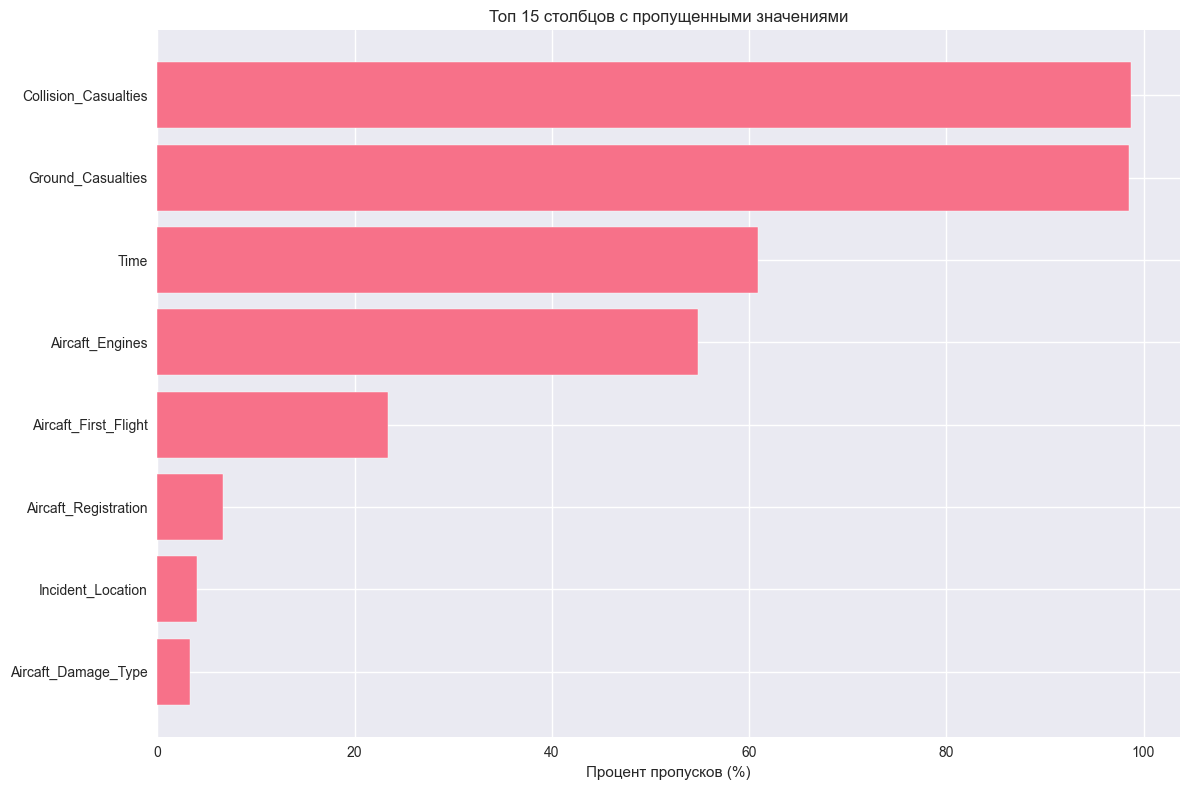

In [37]:
# Визуализация пропущенных значений
plt.figure(figsize=(12, 8))
missing_df_plot = missing_df.head(15)  # Топ 15 столбцов с пропусками
plt.barh(range(len(missing_df_plot)), missing_df_plot['Процент пропусков'])
plt.yticks(range(len(missing_df_plot)), missing_df_plot.index)
plt.xlabel('Процент пропусков (%)')
plt.title('Топ 15 столбцов с пропущенными значениями')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [38]:
# ОБОСНОВАНИЕ И ОБРАБОТКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ

print("=" * 80)
print("ОБОСНОВАНИЕ МЕТОДОВ ОБРАБОТКИ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ")
print("=" * 80)

# Создаем копию датасета для работы
df_processed = df.copy()

# 1. Для числовых признаков с небольшим процентом пропусков (< 30%) - заполняем медианой
# 2. Для категориальных признаков - заполняем модой или 'Unknown'
# 3. Для признаков с большим процентом пропусков (> 50%) - рассматриваем удаление

# Извлечение числовых значений из строковых полей с помощью регулярных выражений
def extract_number(text, default=0):
    """Извлекает первое число из текста"""
    if pd.isna(text) or text == '':
        return default
    numbers = re.findall(r'\d+', str(text))
    return int(numbers[0]) if numbers else default

# Обработка столбцов с числовыми данными в текстовом формате
print("\n1. Обработка столбцов с числовыми данными в текстовом формате:")

# Onboard_Crew, Onboard_Passengers, Onboard_Total
for col in ['Onboard_Crew', 'Onboard_Passengers', 'Onboard_Total']:
    if col in df_processed.columns:
        df_processed[f'{col}_numeric'] = df_processed[col].apply(
            lambda x: extract_number(str(x).split('/')[-1]) if pd.notna(x) else 0
        )
        print(f"   - {col}: создан {col}_numeric")

# Fatalities уже числовой, но проверим
if 'Fatalities' in df_processed.columns:
    df_processed['Fatalities'] = pd.to_numeric(df_processed['Fatalities'], errors='coerce').fillna(0)

# Aircaft_Engines - извлекаем количество двигателей
if 'Aircaft_Engines' in df_processed.columns:
    df_processed['Num_Engines'] = df_processed['Aircaft_Engines'].apply(
        lambda x: extract_number(str(x)) if pd.notna(x) and str(x) != '' else 1
    )
    print(f"   - Aircaft_Engines: создан Num_Engines")

# Aircaft_First_Flight - извлекаем год
if 'Aircaft_First_Flight' in df_processed.columns:
    def extract_year(text):
        if pd.isna(text) or text == '':
            return None
        years = re.findall(r'\b(19|20)\d{2}\b', str(text))
        return int(years[0]) if years else None
    
    df_processed['First_Flight_Year'] = df_processed['Aircaft_First_Flight'].apply(extract_year)
    print(f"   - Aircaft_First_Flight: создан First_Flight_Year")

print("\n2. Заполнение пропусков в категориальных признаках:")
# Заполнение категориальных признаков
categorical_cols = df_processed.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df_processed[col].isnull().sum() > 0:
        if df_processed[col].isnull().sum() / len(df_processed) < 0.5:  # Если пропусков < 50%
            mode_value = df_processed[col].mode()[0] if not df_processed[col].mode().empty else 'Unknown'
            df_processed[col].fillna(mode_value, inplace=True)
            print(f"   - {col}: заполнено модой ({mode_value})")
        else:
            df_processed[col].fillna('Unknown', inplace=True)
            print(f"   - {col}: заполнено 'Unknown' (много пропусков)")

print("\n3. Заполнение пропусков в числовых признаках:")
# Заполнение числовых признаков медианой
numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df_processed[col].isnull().sum() > 0:
        median_value = df_processed[col].median()
        df_processed[col].fillna(median_value, inplace=True)
        print(f"   - {col}: заполнено медианой ({median_value:.2f})")

print("\n✓ Обработка пропущенных значений завершена!")


ОБОСНОВАНИЕ МЕТОДОВ ОБРАБОТКИ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ

1. Обработка столбцов с числовыми данными в текстовом формате:
   - Onboard_Crew: создан Onboard_Crew_numeric
   - Onboard_Passengers: создан Onboard_Passengers_numeric
   - Onboard_Total: создан Onboard_Total_numeric
   - Aircaft_Engines: создан Num_Engines
   - Aircaft_First_Flight: создан First_Flight_Year

2. Заполнение пропусков в категориальных признаках:
   - Aircaft_Registration: заполнено модой (LZ-...)
   - Incident_Location: заполнено модой (unknown)
   - Aircaft_Damage_Type: заполнено модой (Damaged beyond repair)
   - Time: заполнено 'Unknown' (много пропусков)
   - Aircaft_Engines: заполнено 'Unknown' (много пропусков)
   - Aircaft_First_Flight: заполнено модой (1944)
   - Ground_Casualties: заполнено 'Unknown' (много пропусков)
   - Collision_Casualties: заполнено 'Unknown' (много пропусков)

3. Заполнение пропусков в числовых признаках:
   - First_Flight_Year: заполнено медианой (19.00)

✓ Обработка пропущенных значени

In [39]:
# Проверка результата обработки
print("Проверка пропущенных значений после обработки:")
print(f"Осталось пропусков: {df_processed.isnull().sum().sum()}")
if df_processed.isnull().sum().sum() > 0:
    print("\nСтолбцы с оставшимися пропусками:")
    remaining_missing = df_processed.isnull().sum()
    print(remaining_missing[remaining_missing > 0])
else:
    print("✓ Все пропуски обработаны!")


Проверка пропущенных значений после обработки:
Осталось пропусков: 0
✓ Все пропуски обработаны!


## 3. Изменение структуры набора данных и работа со строками с помощью регулярных выражений


In [40]:
# Изменение структуры данных с использованием регулярных выражений

print("=" * 80)
print("ИЗМЕНЕНИЕ СТРУКТУРЫ ДАННЫХ С ИСПОЛЬЗОВАНИЕМ РЕГУЛЯРНЫХ ВЫРАЖЕНИЙ")
print("=" * 80)

# 1. Извлечение информации из Incident_Date
print("\n1. Обработка Incident_Date:")
df_processed['Incident_Date'] = pd.to_datetime(df_processed['Incident_Date'], errors='coerce')
df_processed['Incident_Year'] = df_processed['Incident_Date'].dt.year
df_processed['Incident_Month'] = df_processed['Incident_Date'].dt.month
df_processed['Incident_DayOfWeek'] = df_processed['Incident_Date'].dt.dayofweek
print("   - Созданы: Incident_Year, Incident_Month, Incident_DayOfWeek")

# 2. Извлечение времени из Time
print("\n2. Обработка Time:")
def extract_hour(time_str):
    """Извлекает час из строки времени"""
    if pd.isna(time_str) or time_str == '':
        return 12  # По умолчанию полдень
    # Ищем паттерны времени: HH:MM, HH.MM, ca HH:MM, etc.
    time_patterns = [
        r'(\d{1,2}):(\d{2})',  # HH:MM
        r'(\d{1,2})\.(\d{2})',  # HH.MM
        r'ca\.?\s*(\d{1,2})',   # ca. HH
        r'c\.\s*(\d{1,2})',     # c. HH
    ]
    for pattern in time_patterns:
        match = re.search(pattern, str(time_str))
        if match:
            return int(match.group(1))
    return 12

df_processed['Incident_Hour'] = df_processed['Time'].apply(extract_hour)
print("   - Создан: Incident_Hour")

# 3. Обработка Incident_Category - разделение на тип и серьезность
print("\n3. Обработка Incident_Category:")
def split_incident_category(category):
    """Разделяет категорию инцидента на тип и серьезность"""
    if pd.isna(category) or category == '':
        return 'Unknown', 'Unknown'
    parts = str(category).split('|')
    if len(parts) == 2:
        return parts[0].strip(), parts[1].strip()
    return category.strip(), 'Unknown'

df_processed[['Incident_Type', 'Incident_Severity']] = df_processed['Incident_Category'].apply(
    lambda x: pd.Series(split_incident_category(x))
)
print("   - Созданы: Incident_Type, Incident_Severity")

# 4. Извлечение страны из аэропортов
print("\n4. Извлечение стран из аэропортов:")
def extract_country(airport_str):
    """Извлекает страну из строки аэропорта"""
    if pd.isna(airport_str) or airport_str == '' or airport_str == '?' or airport_str == '-':
        return 'Unknown'
    # Ищем паттерн ", Country" в конце строки
    match = re.search(r',\s*([^,]+)$', str(airport_str))
    if match:
        return match.group(1).strip()
    return 'Unknown'

df_processed['Departure_Country'] = df_processed['Departure_Airport'].apply(extract_country)
df_processed['Destination_Country'] = df_processed['Destination_Airport'].apply(extract_country)
print("   - Созданы: Departure_Country, Destination_Country")

# 5. Обработка Aircaft_Damage_Type - создание бинарного признака серьезности
print("\n5. Обработка Aircaft_Damage_Type:")
damage_severity_map = {
    'None': 0,
    'Substantial': 1,
    'Destroyed': 2,
    'Damaged beyond repair': 2,
    'Unknown': 0
}
df_processed['Damage_Severity_Score'] = df_processed['Aircaft_Damage_Type'].map(
    damage_severity_map
).fillna(0)
print("   - Создан: Damage_Severity_Score")

# 6. Извлечение количества причин из Incident_Cause(es)
print("\n6. Обработка Incident_Cause(es):")
df_processed['Num_Causes'] = df_processed['Incident_Cause(es)'].apply(
    lambda x: len(str(x).split(',')) if pd.notna(x) and str(x) != '' else 0
)
print("   - Создан: Num_Causes")

# 7. Создание признака возраста самолета на момент инцидента
print("\n7. Создание признака возраста самолета:")
df_processed['Aircraft_Age'] = df_processed['Incident_Year'] - df_processed['First_Flight_Year']
df_processed['Aircraft_Age'] = df_processed['Aircraft_Age'].apply(
    lambda x: x if pd.notna(x) and x > 0 and x < 100 else None
)
df_processed['Aircraft_Age'].fillna(df_processed['Aircraft_Age'].median(), inplace=True)
print("   - Создан: Aircraft_Age")

print("\n✓ Изменение структуры данных завершено!")
print(f"Новое количество столбцов: {df_processed.shape[1]}")


ИЗМЕНЕНИЕ СТРУКТУРЫ ДАННЫХ С ИСПОЛЬЗОВАНИЕМ РЕГУЛЯРНЫХ ВЫРАЖЕНИЙ

1. Обработка Incident_Date:
   - Созданы: Incident_Year, Incident_Month, Incident_DayOfWeek

2. Обработка Time:
   - Создан: Incident_Hour

3. Обработка Incident_Category:
   - Созданы: Incident_Type, Incident_Severity

4. Извлечение стран из аэропортов:
   - Созданы: Departure_Country, Destination_Country

5. Обработка Aircaft_Damage_Type:
   - Создан: Damage_Severity_Score

6. Обработка Incident_Cause(es):
   - Создан: Num_Causes

7. Создание признака возраста самолета:
   - Создан: Aircraft_Age

✓ Изменение структуры данных завершено!
Новое количество столбцов: 39


In [41]:
# КОДИРОВАНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ
# Используем минимум 2 метода: Label Encoding и One-Hot Encoding

print("=" * 80)
print("КОДИРОВАНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ")
print("=" * 80)

# Выбираем целевой признак для классификации
# Используем Aircaft_Damage_Type как целевую переменную
target_column = 'Aircaft_Damage_Type'
print(f"\nЦелевая переменная: {target_column}")
print(f"Классы целевой переменной:")
print(df_processed[target_column].value_counts())

# Подготовка данных для кодирования
df_encoded = df_processed.copy()

# Выбираем категориальные признаки для кодирования
categorical_features = [
    'Aircaft_Nature', 'Incident_Type', 'Aircraft_Phase', 
    'Departure_Country', 'Destination_Country'
]

print(f"\nКатегориальные признаки для кодирования: {categorical_features}")

# МЕТОД 1: LABEL ENCODING
print("\n" + "="*80)
print("МЕТОД 1: LABEL ENCODING")
print("="*80)

label_encoders = {}
for col in categorical_features:
    if col in df_encoded.columns:
        le = LabelEncoder()
        df_encoded[f'{col}_LabelEncoded'] = le.fit_transform(df_encoded[col].astype(str))
        label_encoders[col] = le
        print(f"   - {col}: закодирован как {col}_LabelEncoded")
        print(f"     Количество уникальных значений: {df_encoded[col].nunique()}")

# Кодирование целевой переменной
le_target = LabelEncoder()
df_encoded['Target_LabelEncoded'] = le_target.fit_transform(df_encoded[target_column].astype(str))
print(f"\n   - {target_column}: закодирован как Target_LabelEncoded")
print(f"     Классы: {dict(zip(le_target.classes_, range(len(le_target.classes_))))}")

# МЕТОД 2: ONE-HOT ENCODING
print("\n" + "="*80)
print("МЕТОД 2: ONE-HOT ENCODING")
print("="*80)

# Применяем One-Hot Encoding к признакам с небольшим количеством уникальных значений
for col in categorical_features:
    if col in df_encoded.columns:
        unique_count = df_encoded[col].nunique()
        if unique_count <= 20:  # One-Hot только для признаков с <= 20 уникальными значениями
            ohe = OneHotEncoder(sparse_output=False, drop='first')
            ohe_data = ohe.fit_transform(df_encoded[[col]])
            ohe_columns = [f'{col}_OHE_{cat}' for cat in ohe.categories_[0][1:]]
            ohe_df = pd.DataFrame(ohe_data, columns=ohe_columns, index=df_encoded.index)
            df_encoded = pd.concat([df_encoded, ohe_df], axis=1)
            print(f"   - {col}: создано {len(ohe_columns)} бинарных признаков (One-Hot)")
        else:
            print(f"   - {col}: пропущен (слишком много уникальных значений: {unique_count})")

print("\n✓ Кодирование категориальных признаков завершено!")
print(f"Новое количество столбцов: {df_encoded.shape[1]}")


КОДИРОВАНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ

Целевая переменная: Aircaft_Damage_Type
Классы целевой переменной:
Aircaft_Damage_Type
Damaged beyond repair    16670
Substantial               3267
Destroyed                 2594
Missing                    365
Unknown                    339
Minor                      284
Name: count, dtype: int64

Категориальные признаки для кодирования: ['Aircaft_Nature', 'Incident_Type', 'Aircraft_Phase', 'Departure_Country', 'Destination_Country']

МЕТОД 1: LABEL ENCODING
   - Aircaft_Nature: закодирован как Aircaft_Nature_LabelEncoded
     Количество уникальных значений: 25
   - Incident_Type: закодирован как Incident_Type_LabelEncoded
     Количество уникальных значений: 6
   - Aircraft_Phase: закодирован как Aircraft_Phase_LabelEncoded
     Количество уникальных значений: 12
   - Departure_Country: закодирован как Departure_Country_LabelEncoded
     Количество уникальных значений: 217
   - Destination_Country: закодирован как Destination_Country_LabelEncoded

ВИЗУАЛИЗАЦИЯ ДАННЫХ

1. Гистограмма распределения целевой переменной


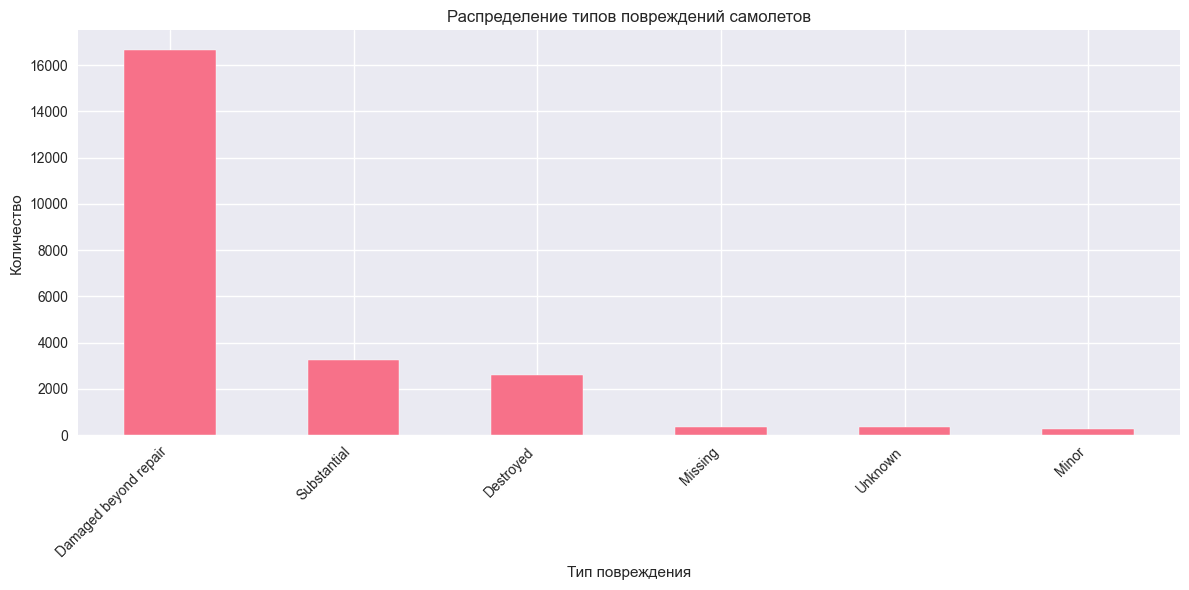

In [42]:
# ВИЗУАЛИЗАЦИЯ ДАННЫХ (минимум 5 методов)

print("=" * 80)
print("ВИЗУАЛИЗАЦИЯ ДАННЫХ")
print("=" * 80)

# Метод 1: Гистограмма распределения целевой переменной
print("\n1. Гистограмма распределения целевой переменной")
plt.figure(figsize=(12, 6))
df_encoded[target_column].value_counts().plot(kind='bar')
plt.title('Распределение типов повреждений самолетов')
plt.xlabel('Тип повреждения')
plt.ylabel('Количество')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



2. Гистограммы распределений числовых признаков


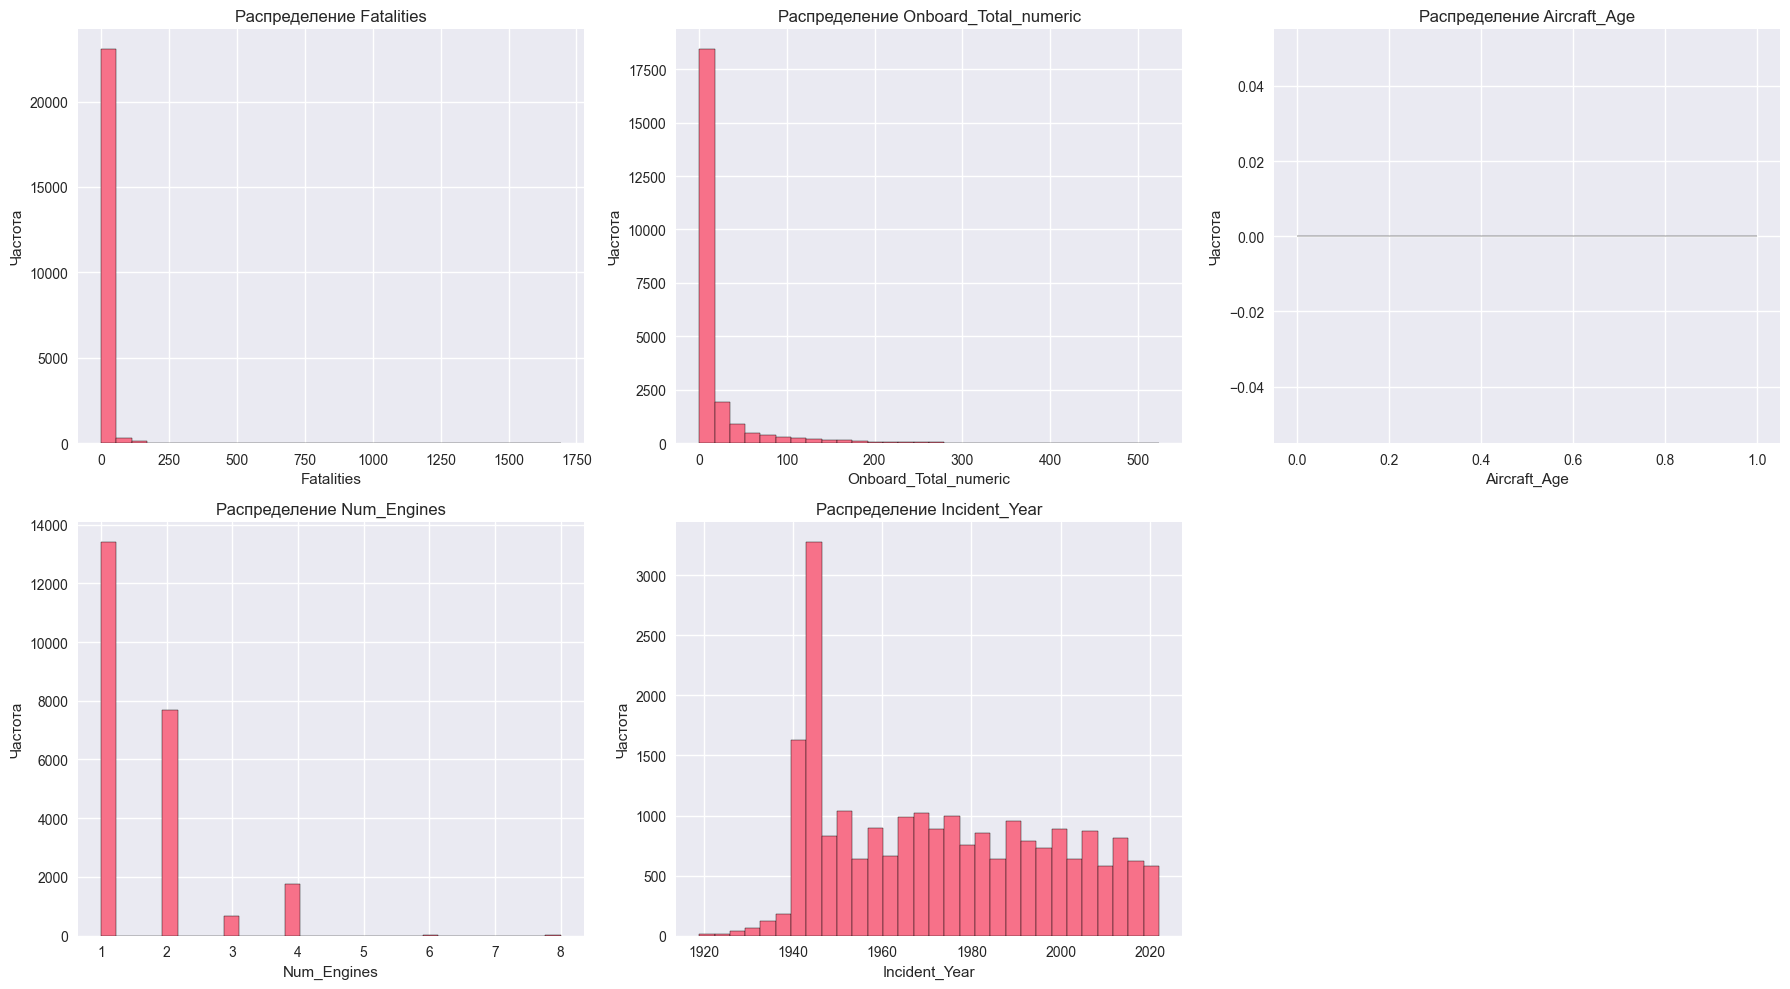

In [43]:
# Метод 2: Гистограммы распределений числовых признаков
print("\n2. Гистограммы распределений числовых признаков")
numeric_cols_for_viz = ['Fatalities', 'Onboard_Total_numeric', 'Aircraft_Age', 
                        'Num_Engines', 'Incident_Year']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_cols_for_viz):
    if col in df_encoded.columns:
        df_encoded[col].hist(bins=30, ax=axes[i], edgecolor='black')
        axes[i].set_title(f'Распределение {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Частота')

# Удаляем лишние subplot
if len(numeric_cols_for_viz) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()



3. Матрица корреляций числовых признаков


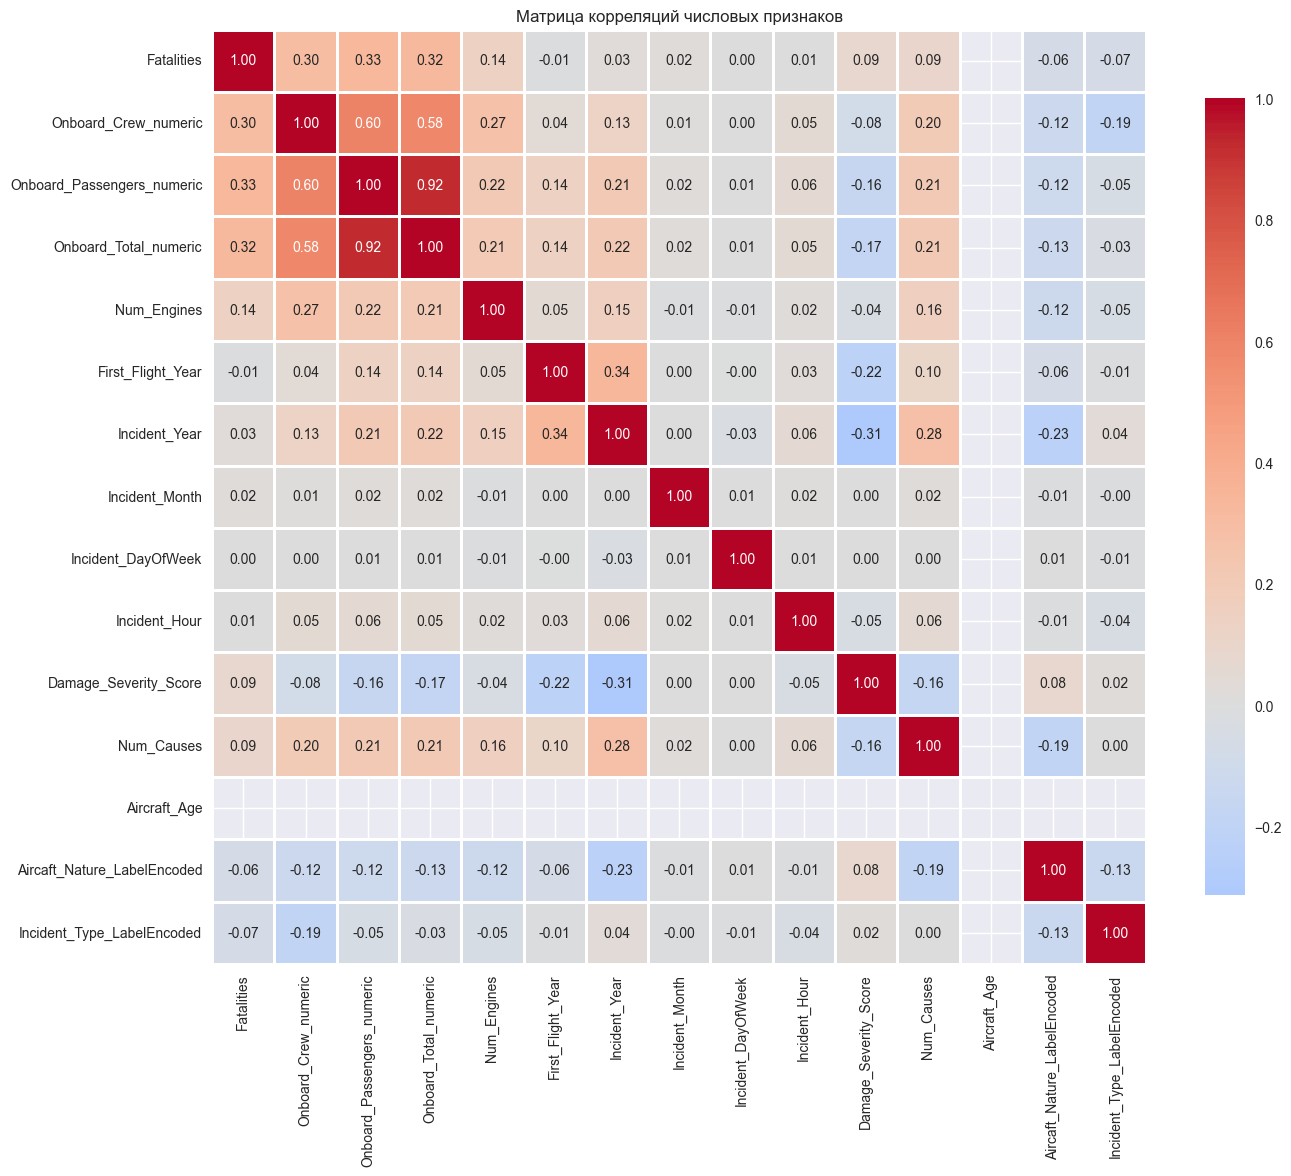

In [44]:
# Метод 3: Матрица корреляций
print("\n3. Матрица корреляций числовых признаков")
numeric_cols_corr = df_encoded.select_dtypes(include=[np.number]).columns.tolist()
# Оставляем только релевантные числовые признаки
numeric_cols_corr = [col for col in numeric_cols_corr if not col.endswith('_OHE_') and 
                     col not in ['Target_LabelEncoded']][:15]  # Берем первые 15

if len(numeric_cols_corr) > 1:
    corr_matrix = df_encoded[numeric_cols_corr].corr()
    plt.figure(figsize=(14, 12))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Матрица корреляций числовых признаков')
    plt.tight_layout()
    plt.show()



4. Box plot: Распределение Fatalities по типам повреждений


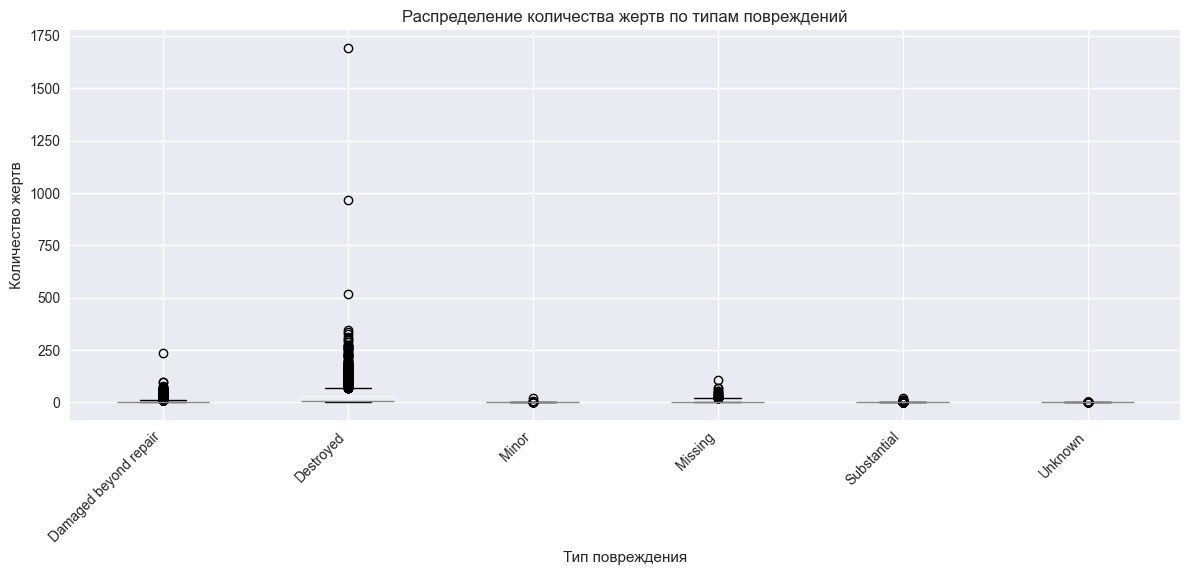

In [45]:
# Метод 4: Box plot для категориальных признаков
print("\n4. Box plot: Распределение Fatalities по типам повреждений")
plt.figure(figsize=(12, 6))
df_encoded.boxplot(column='Fatalities', by=target_column, ax=plt.gca())
plt.title('Распределение количества жертв по типам повреждений')
plt.suptitle('')  # Убираем автоматический заголовок
plt.xlabel('Тип повреждения')
plt.ylabel('Количество жертв')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



5. Столбчатая диаграмма: Распределение инцидентов по странам отправления


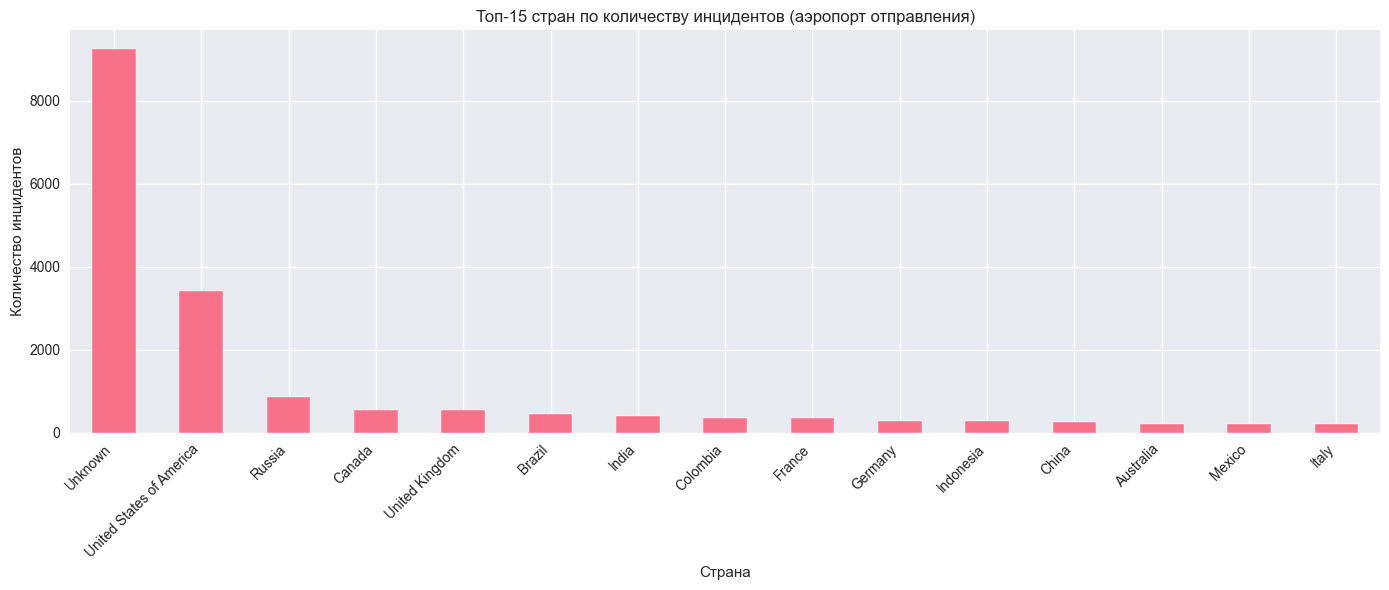

In [46]:
# Метод 5: Столбчатая диаграмма для категориальных признаков
print("\n5. Столбчатая диаграмма: Распределение инцидентов по странам отправления")
top_countries = df_encoded['Departure_Country'].value_counts().head(15)
plt.figure(figsize=(14, 6))
top_countries.plot(kind='bar')
plt.title('Топ-15 стран по количеству инцидентов (аэропорт отправления)')
plt.xlabel('Страна')
plt.ylabel('Количество инцидентов')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



6. Scatter plot: Связь между возрастом самолета и количеством жертв


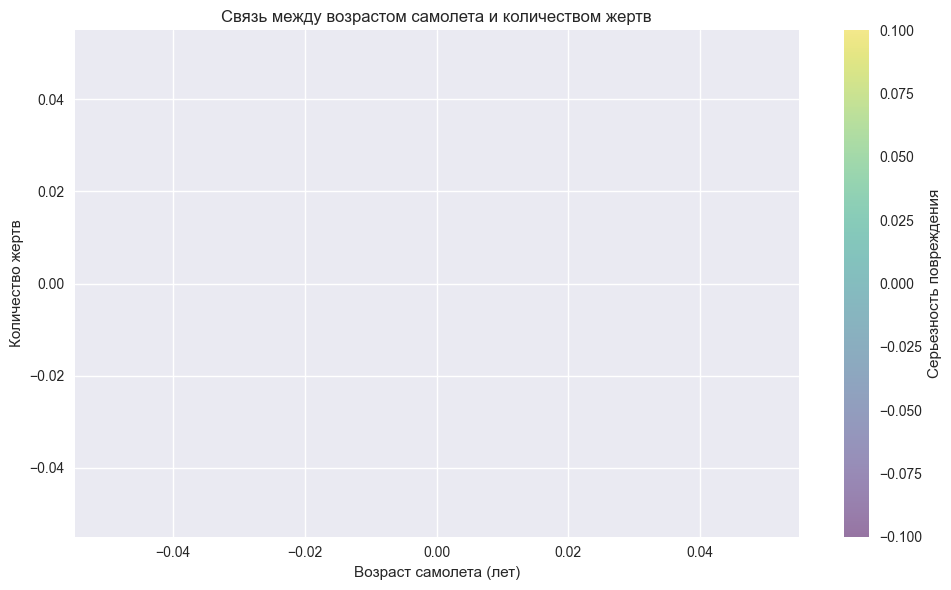

In [47]:
# Метод 6: Scatter plot (дополнительная визуализация)
print("\n6. Scatter plot: Связь между возрастом самолета и количеством жертв")
plt.figure(figsize=(10, 6))
plt.scatter(df_encoded['Aircraft_Age'], df_encoded['Fatalities'], 
            alpha=0.5, s=50, c=df_encoded['Damage_Severity_Score'], cmap='viridis')
plt.colorbar(label='Серьезность повреждения')
plt.xlabel('Возраст самолета (лет)')
plt.ylabel('Количество жертв')
plt.title('Связь между возрастом самолета и количеством жертв')
plt.tight_layout()
plt.show()



7. Круговая диаграмма: Распределение по типам инцидентов


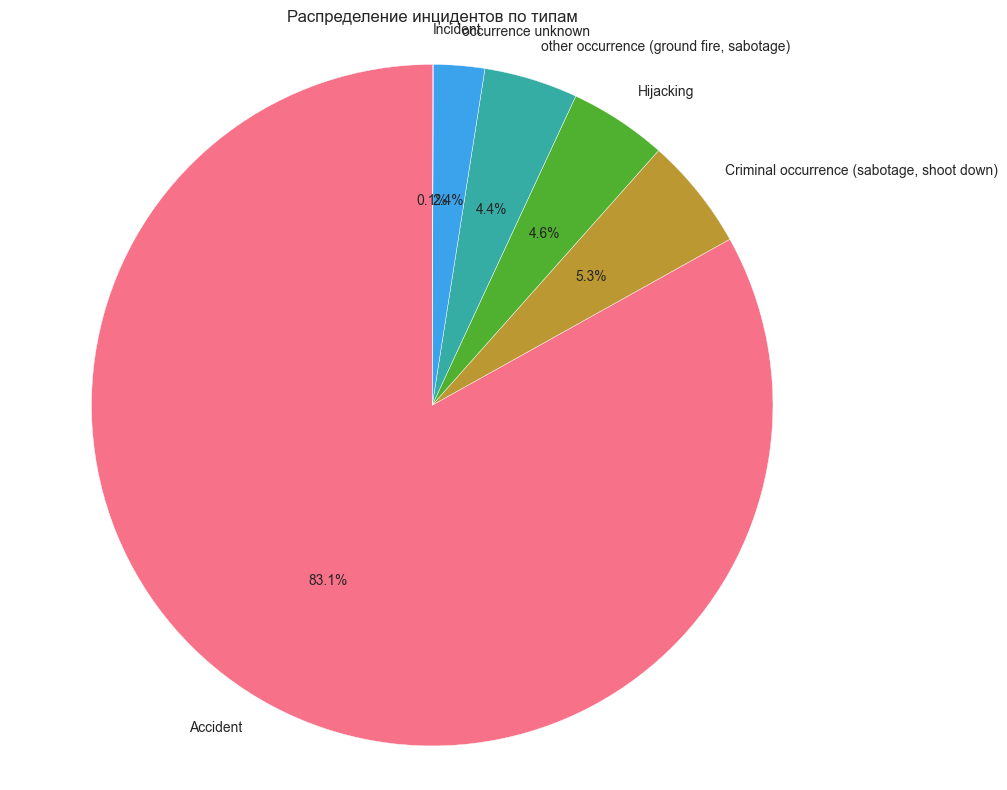


✓ Визуализация данных завершена!


In [48]:
# Метод 7: Pie chart для категориального признака
print("\n7. Круговая диаграмма: Распределение по типам инцидентов")
incident_type_counts = df_encoded['Incident_Type'].value_counts().head(8)
plt.figure(figsize=(10, 8))
plt.pie(incident_type_counts.values, labels=incident_type_counts.index, autopct='%1.1f%%',
        startangle=90, textprops={'fontsize': 10})
plt.title('Распределение инцидентов по типам')
plt.axis('equal')
plt.tight_layout()
plt.show()

print("\n✓ Визуализация данных завершена!")


## 6. Отбор признаков и создание новых признаков


In [49]:
# ОТБОР ПРИЗНАКОВ И СОЗДАНИЕ НОВЫХ ПРИЗНАКОВ

print("=" * 80)
print("ОТБОР ПРИЗНАКОВ")
print("=" * 80)

# Подготовка данных для отбора признаков
# Выбираем все числовые признаки (кроме целевой переменной)
feature_cols = [col for col in df_encoded.select_dtypes(include=[np.number]).columns 
                if col != 'Target_LabelEncoded']

print(f"\nИсходное количество признаков: {len(feature_cols)}")

# МЕТОД 1: Удаление признаков с низкой дисперсией
print("\n1. Удаление признаков с низкой дисперсией:")
variance_selector = VarianceThreshold(threshold=0.01)
X_temp = df_encoded[feature_cols].fillna(0)
variance_selector.fit(X_temp)
selected_features_variance = [feature_cols[i] for i in range(len(feature_cols)) 
                              if variance_selector.variances_[i] > 0.01]
print(f"   Признаков после удаления низкой дисперсии: {len(selected_features_variance)}")
print(f"   Удалено признаков: {len(feature_cols) - len(selected_features_variance)}")


ОТБОР ПРИЗНАКОВ

Исходное количество признаков: 34

1. Удаление признаков с низкой дисперсией:
   Признаков после удаления низкой дисперсии: 30
   Удалено признаков: 4


In [50]:
# МЕТОД 2: Одномерный отбор признаков (SelectKBest)
print("\n2. Одномерный отбор признаков (SelectKBest):")
X_for_selection = df_encoded[selected_features_variance].fillna(0)
y_for_selection = df_encoded['Target_LabelEncoded']

# Используем f_classif для классификации
k_best = 20  # Выбираем топ-20 признаков
selector_kbest = SelectKBest(score_func=f_classif, k=k_best)
selector_kbest.fit(X_for_selection, y_for_selection)
selected_features_kbest = [selected_features_variance[i] for i in 
                           selector_kbest.get_support(indices=True)]

print(f"   Выбрано топ-{k_best} признаков по F-статистике")
print(f"   Лучшие признаки:")
feature_scores = pd.DataFrame({
    'Признак': selected_features_variance,
    'F-статистика': selector_kbest.scores_
}).sort_values('F-статистика', ascending=False).head(k_best)
print(feature_scores)



2. Одномерный отбор признаков (SelectKBest):
   Выбрано топ-20 признаков по F-статистике
   Лучшие признаки:
                              Признак  F-статистика
10              Damage_Severity_Score           inf
18        Incident_Type_OHE_Hijacking   1187.455517
0                          Fatalities    649.514454
5                   First_Flight_Year    507.777251
11                         Num_Causes    503.076859
24   Aircraft_Phase_OHE_Landing (LDG)    491.659077
29   Aircraft_Phase_OHE_Unknown (UNK)    369.861547
2          Onboard_Passengers_numeric    367.774929
3               Onboard_Total_numeric    349.923940
1                Onboard_Crew_numeric    286.996015
14        Aircraft_Phase_LabelEncoded    275.316497
22  Aircraft_Phase_OHE_En route (ENR)    228.989875
4                         Num_Engines    228.685104
28      Aircraft_Phase_OHE_Taxi (TXI)    172.519124
21  Aircraft_Phase_OHE_Approach (APR)    160.343309
12        Aircaft_Nature_LabelEncoded    156.029973
13    

In [51]:
# МЕТОД 3: Рекурсивное исключение признаков (RFE)
print("\n3. Рекурсивное исключение признаков (RFE):")
# Используем Random Forest как базовую модель для RFE
rf_base = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rfe_selector = RFE(estimator=rf_base, n_features_to_select=15, step=1)
rfe_selector.fit(X_for_selection, y_for_selection)
selected_features_rfe = [selected_features_variance[i] for i in 
                         rfe_selector.get_support(indices=True)]

print(f"   Выбрано 15 признаков методом RFE")
print(f"   Отобранные признаки:")
for i, feature in enumerate(selected_features_rfe, 1):
    print(f"   {i}. {feature}")

# Объединяем результаты отбора признаков
final_features = list(set(selected_features_kbest + selected_features_rfe))
print(f"\n   Итоговое количество отобранных признаков: {len(final_features)}")



3. Рекурсивное исключение признаков (RFE):
   Выбрано 15 признаков методом RFE
   Отобранные признаки:
   1. Fatalities
   2. Onboard_Crew_numeric
   3. Onboard_Passengers_numeric
   4. Onboard_Total_numeric
   5. Incident_Year
   6. Incident_Month
   7. Incident_DayOfWeek
   8. Incident_Hour
   9. Damage_Severity_Score
   10. Num_Causes
   11. Aircaft_Nature_LabelEncoded
   12. Aircraft_Phase_LabelEncoded
   13. Departure_Country_LabelEncoded
   14. Destination_Country_LabelEncoded
   15. Incident_Type_OHE_Hijacking

   Итоговое количество отобранных признаков: 23


In [52]:
# СОЗДАНИЕ НОВЫХ ПРИЗНАКОВ ИЗ СУЩЕСТВУЮЩИХ

print("\n" + "="*80)
print("СОЗДАНИЕ НОВЫХ ПРИЗНАКОВ")
print("="*80)

# 1. Признак соотношения жертв к общему количеству на борту
if 'Fatalities' in df_encoded.columns and 'Onboard_Total_numeric' in df_encoded.columns:
    df_encoded['Fatality_Rate'] = df_encoded['Fatalities'] / (df_encoded['Onboard_Total_numeric'] + 1)
    final_features.append('Fatality_Rate')
    print("1. Создан признак: Fatality_Rate (соотношение жертв к общему количеству)")

# 2. Признак времени суток (утро, день, вечер, ночь)
if 'Incident_Hour' in df_encoded.columns:
    def time_of_day(hour):
        if 5 <= hour < 12:
            return 0  # Утро
        elif 12 <= hour < 17:
            return 1  # День
        elif 17 <= hour < 22:
            return 2  # Вечер
        else:
            return 3  # Ночь
    
    df_encoded['TimeOfDay'] = df_encoded['Incident_Hour'].apply(time_of_day)
    final_features.append('TimeOfDay')
    print("2. Создан признак: TimeOfDay (время суток)")

# 3. Признак сезона
if 'Incident_Month' in df_encoded.columns:
    def get_season(month):
        if month in [12, 1, 2]:
            return 0  # Зима
        elif month in [3, 4, 5]:
            return 1  # Весна
        elif month in [6, 7, 8]:
            return 2  # Лето
        else:
            return 3  # Осень
    
    df_encoded['Season'] = df_encoded['Incident_Month'].apply(get_season)
    final_features.append('Season')
    print("3. Создан признак: Season (сезон)")

# 4. Признак: внутренний или международный рейс
if 'Departure_Country' in df_encoded.columns and 'Destination_Country' in df_encoded.columns:
    df_encoded['Is_Domestic'] = (df_encoded['Departure_Country'] == 
                                 df_encoded['Destination_Country']).astype(int)
    final_features.append('Is_Domestic')
    print("4. Создан признак: Is_Domestic (внутренний/международный рейс)")

# 5. Признак: есть ли жертвы (бинарный)
if 'Fatalities' in df_encoded.columns:
    df_encoded['Has_Fatalities'] = (df_encoded['Fatalities'] > 0).astype(int)
    final_features.append('Has_Fatalities')
    print("5. Создан признак: Has_Fatalities (наличие жертв)")

print(f"\n✓ Создание новых признаков завершено!")
print(f"Итоговое количество признаков для обучения: {len(final_features)}")



СОЗДАНИЕ НОВЫХ ПРИЗНАКОВ
1. Создан признак: Fatality_Rate (соотношение жертв к общему количеству)
2. Создан признак: TimeOfDay (время суток)
3. Создан признак: Season (сезон)
4. Создан признак: Is_Domestic (внутренний/международный рейс)
5. Создан признак: Has_Fatalities (наличие жертв)

✓ Создание новых признаков завершено!
Итоговое количество признаков для обучения: 28


## 7. Проверка сбалансированности классов целевого признака


ПРОВЕРКА СБАЛАНСИРОВАННОСТИ КЛАССОВ

Распределение классов целевой переменной 'Aircaft_Damage_Type':
Aircaft_Damage_Type
Damaged beyond repair    16670
Substantial               3267
Destroyed                 2594
Missing                    365
Unknown                    339
Minor                      284
Name: count, dtype: int64

Процентное распределение:
Aircaft_Damage_Type
Damaged beyond repair    70.878864
Substantial              13.890897
Destroyed                11.029381
Missing                   1.551937
Unknown                   1.441388
Minor                     1.207534
Name: count, dtype: float64


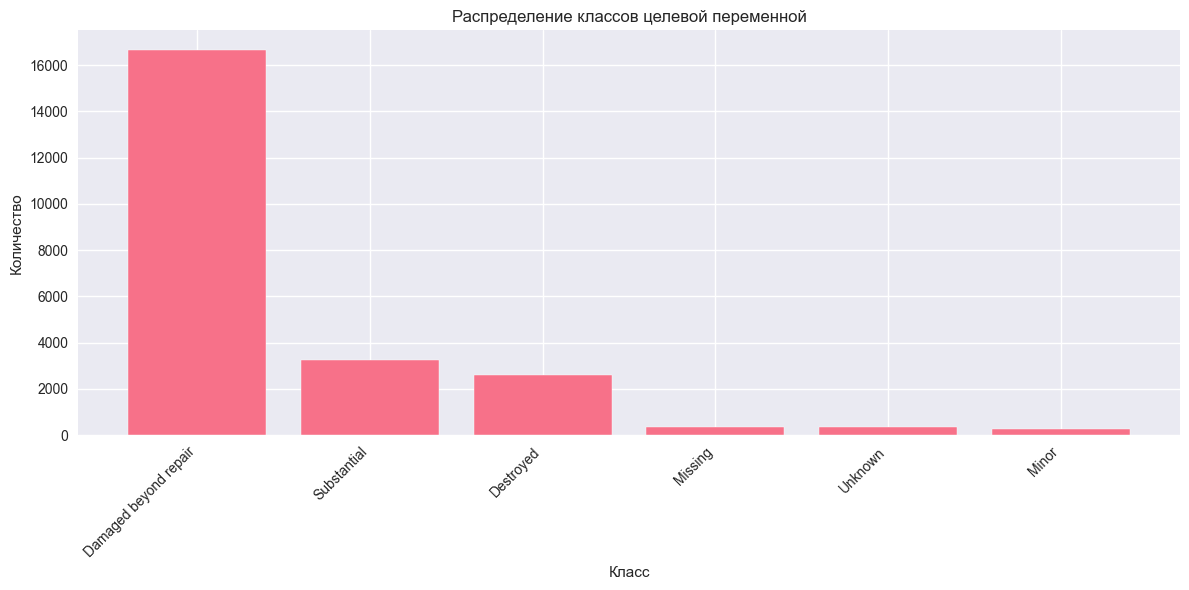


Максимальная доля класса: 70.88%
Минимальная доля класса: 1.21%
Коэффициент дисбаланса: 58.70

⚠ ВНИМАНИЕ: Классы несбалансированы! Рекомендуется использовать:
   - class_weight='balanced' в моделях
   - Метрики: precision, recall, F1-score (вместо только accuracy)
   - Методы балансировки: SMOTE, undersampling, oversampling


In [53]:
# ПРОВЕРКА СБАЛАНСИРОВАННОСТИ КЛАССОВ

print("=" * 80)
print("ПРОВЕРКА СБАЛАНСИРОВАННОСТИ КЛАССОВ")
print("=" * 80)

target_counts = df_encoded[target_column].value_counts()
target_proportions = target_counts / len(df_encoded) * 100

print(f"\nРаспределение классов целевой переменной '{target_column}':")
print(target_counts)
print(f"\nПроцентное распределение:")
print(target_proportions)

# Визуализация
plt.figure(figsize=(12, 6))
plt.bar(range(len(target_counts)), target_counts.values)
plt.xticks(range(len(target_counts)), target_counts.index, rotation=45, ha='right')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.title('Распределение классов целевой переменной')
plt.tight_layout()
plt.show()

# Оценка сбалансированности
max_proportion = target_proportions.max()
min_proportion = target_proportions.min()
imbalance_ratio = max_proportion / min_proportion

print(f"\nМаксимальная доля класса: {max_proportion:.2f}%")
print(f"Минимальная доля класса: {min_proportion:.2f}%")
print(f"Коэффициент дисбаланса: {imbalance_ratio:.2f}")

if imbalance_ratio > 3:
    print("\n⚠ ВНИМАНИЕ: Классы несбалансированы! Рекомендуется использовать:")
    print("   - class_weight='balanced' в моделях")
    print("   - Метрики: precision, recall, F1-score (вместо только accuracy)")
    print("   - Методы балансировки: SMOTE, undersampling, oversampling")
else:
    print("\n✓ Классы относительно сбалансированы")


## 8. Разбиение набора данных на X и y, train и test


In [54]:
# РАЗБИЕНИЕ НА X И Y, TRAIN И TEST

print("=" * 80)
print("РАЗБИЕНИЕ НАБОРА ДАННЫХ")
print("=" * 80)

# Подготовка признаков и целевой переменной
X = df_encoded[final_features].fillna(0)
y = df_encoded['Target_LabelEncoded']

print(f"\nРазмерность X: {X.shape}")
print(f"Размерность y: {y.shape}")
print(f"Количество признаков: {len(final_features)}")

# Разбиение на train и test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nРазмерность X_train: {X_train.shape}")
print(f"Размерность X_test: {X_test.shape}")
print(f"Размерность y_train: {y_train.shape}")
print(f"Размерность y_test: {y_test.shape}")

# Проверка распределения классов в train и test
print("\nРаспределение классов в обучающей выборке:")
print(y_train.value_counts().sort_index())
print("\nРаспределение классов в тестовой выборке:")
print(y_test.value_counts().sort_index())


РАЗБИЕНИЕ НАБОРА ДАННЫХ

Размерность X: (23519, 28)
Размерность y: (23519,)
Количество признаков: 28

Размерность X_train: (18815, 28)
Размерность X_test: (4704, 28)
Размерность y_train: (18815,)
Размерность y_test: (4704,)

Распределение классов в обучающей выборке:
Target_LabelEncoded
0    13336
1     2075
2      227
3      292
4     2614
5      271
Name: count, dtype: int64

Распределение классов в тестовой выборке:
Target_LabelEncoded
0    3334
1     519
2      57
3      73
4     653
5      68
Name: count, dtype: int64


## 9. Нормализация набора данных


In [55]:
# НОРМАЛИЗАЦИЯ ДАННЫХ

print("=" * 80)
print("НОРМАЛИЗАЦИЯ ДАННЫХ")
print("=" * 80)

# Проверяем необходимость нормализации
print("\nПроверка масштаба признаков (первые 5):")
print(X_train.iloc[:, :5].describe())

# Применяем StandardScaler для нормализации
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Преобразуем обратно в DataFrame для удобства
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("\nПосле нормализации (первые 5 признаков):")
print(X_train_scaled.iloc[:, :5].describe())

print("\n✓ Нормализация завершена!")
print("   Используем нормализованные данные для моделей, требующих масштабирования")
print("   (KNN, нейронные сети)")
print("   Для деревьев решений и ансамблей нормализация не требуется")


НОРМАЛИЗАЦИЯ ДАННЫХ

Проверка масштаба признаков (первые 5):
       Incident_Type_OHE_Hijacking  Aircraft_Phase_OHE_Approach (APR)  \
count                 18815.000000                       18815.000000   
mean                      0.046824                           0.111613   
std                       0.211268                           0.314898   
min                       0.000000                           0.000000   
25%                       0.000000                           0.000000   
50%                       0.000000                           0.000000   
75%                       0.000000                           0.000000   
max                       1.000000                           1.000000   

       Destination_Country_LabelEncoded   Num_Engines  \
count                      18815.000000  18815.000000   
mean                         160.086952      1.606856   
std                           66.518703      0.868551   
min                            0.000000      1.000000

## 10. Обучение моделей машинного обучения

### 10.1. К-ближайших соседей (KNN)


In [56]:
# МОДЕЛЬ 1: K-БЛИЖАЙШИХ СОСЕДЕЙ (KNN)

print("=" * 80)
print("МОДЕЛЬ 1: K-БЛИЖАЙШИХ СОСЕДЕЙ (KNN)")
print("=" * 80)

# KNN требует нормализованных данных
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1)
knn.fit(X_train_scaled, y_train)

# Предсказания
y_pred_knn = knn.predict(X_test_scaled)
y_pred_proba_knn = knn.predict_proba(X_test_scaled)

# Оценка модели
print("\nОценка модели KNN:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print(f"Precision (macro): {precision_score(y_test, y_pred_knn, average='macro'):.4f}")
print(f"Recall (macro): {recall_score(y_test, y_pred_knn, average='macro'):.4f}")
print(f"F1-score (macro): {f1_score(y_test, y_pred_knn, average='macro'):.4f}")

# ROC-AUC (для многоклассовой классификации используем one-vs-rest)
try:
    roc_auc_knn = roc_auc_score(y_test, y_pred_proba_knn, multi_class='ovr', average='macro')
    print(f"ROC-AUC (macro): {roc_auc_knn:.4f}")
except:
    print("ROC-AUC: не удалось вычислить")

print("\nОтчет о классификации:")
print(classification_report(y_test, y_pred_knn, target_names=le_target.classes_))

# Сохраняем модель для дальнейшего сравнения
models_results = {}
models_results['KNN'] = {
    'model': knn,
    'y_pred': y_pred_knn,
    'y_pred_proba': y_pred_proba_knn,
    'accuracy': accuracy_score(y_test, y_pred_knn),
    'precision': precision_score(y_test, y_pred_knn, average='macro'),
    'recall': recall_score(y_test, y_pred_knn, average='macro'),
    'f1': f1_score(y_test, y_pred_knn, average='macro')
}


МОДЕЛЬ 1: K-БЛИЖАЙШИХ СОСЕДЕЙ (KNN)

Оценка модели KNN:
Accuracy: 0.8733
Precision (macro): 0.8461
Recall (macro): 0.6993
F1-score (macro): 0.7356
ROC-AUC (macro): 0.9042

Отчет о классификации:
                       precision    recall  f1-score   support

Damaged beyond repair       0.90      0.95      0.92      3334
            Destroyed       0.57      0.36      0.44       519
                Minor       0.88      0.25      0.38        57
              Missing       0.90      1.00      0.95        73
          Substantial       0.89      0.93      0.91       653
              Unknown       0.94      0.71      0.81        68

             accuracy                           0.87      4704
            macro avg       0.85      0.70      0.74      4704
         weighted avg       0.86      0.87      0.86      4704



### 10.2. Дерево решений


In [57]:
# МОДЕЛЬ 2: ДЕРЕВО РЕШЕНИЙ

print("=" * 80)
print("МОДЕЛЬ 2: ДЕРЕВО РЕШЕНИЙ")
print("=" * 80)

# Дерево решений не требует нормализации
dt = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    class_weight='balanced'
)
dt.fit(X_train, y_train)

# Предсказания
y_pred_dt = dt.predict(X_test)
y_pred_proba_dt = dt.predict_proba(X_test)

# Оценка модели
print("\nОценка модели Дерево решений:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"Precision (macro): {precision_score(y_test, y_pred_dt, average='macro'):.4f}")
print(f"Recall (macro): {recall_score(y_test, y_pred_dt, average='macro'):.4f}")
print(f"F1-score (macro): {f1_score(y_test, y_pred_dt, average='macro'):.4f}")

try:
    roc_auc_dt = roc_auc_score(y_test, y_pred_proba_dt, multi_class='ovr', average='macro')
    print(f"ROC-AUC (macro): {roc_auc_dt:.4f}")
except:
    print("ROC-AUC: не удалось вычислить")

print("\nОтчет о классификации:")
print(classification_report(y_test, y_pred_dt, target_names=le_target.classes_))

# Важность признаков
feature_importance_dt = pd.DataFrame({
    'Признак': X_train.columns,
    'Важность': dt.feature_importances_
}).sort_values('Важность', ascending=False).head(10)

print("\nТоп-10 важных признаков:")
print(feature_importance_dt)

# Сохраняем результаты
models_results['DecisionTree'] = {
    'model': dt,
    'y_pred': y_pred_dt,
    'y_pred_proba': y_pred_proba_dt,
    'accuracy': accuracy_score(y_test, y_pred_dt),
    'precision': precision_score(y_test, y_pred_dt, average='macro'),
    'recall': recall_score(y_test, y_pred_dt, average='macro'),
    'f1': f1_score(y_test, y_pred_dt, average='macro')
}


МОДЕЛЬ 2: ДЕРЕВО РЕШЕНИЙ

Оценка модели Дерево решений:
Accuracy: 0.8482
Precision (macro): 0.8422
Recall (macro): 0.8831
F1-score (macro): 0.8494
ROC-AUC (macro): 0.9686

Отчет о классификации:
                       precision    recall  f1-score   support

Damaged beyond repair       0.96      0.82      0.89      3334
            Destroyed       0.41      0.80      0.54       519
                Minor       0.76      0.91      0.83        57
              Missing       1.00      1.00      1.00        73
          Substantial       1.00      1.00      1.00       653
              Unknown       0.91      0.76      0.83        68

             accuracy                           0.85      4704
            macro avg       0.84      0.88      0.85      4704
         weighted avg       0.91      0.85      0.87      4704


Топ-10 важных признаков:
                             Признак  Важность
8              Damage_Severity_Score  0.459235
23                     Fatality_Rate  0.156468
0    

### 10.3. Случайный лес


In [58]:
# МОДЕЛЬ 3: СЛУЧАЙНЫЙ ЛЕС

print("=" * 80)
print("МОДЕЛЬ 3: СЛУЧАЙНЫЙ ЛЕС")
print("=" * 80)

# Случайный лес не требует нормализации
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Предсказания
y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)

# Оценка модели
print("\nОценка модели Случайный лес:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision (macro): {precision_score(y_test, y_pred_rf, average='macro'):.4f}")
print(f"Recall (macro): {recall_score(y_test, y_pred_rf, average='macro'):.4f}")
print(f"F1-score (macro): {f1_score(y_test, y_pred_rf, average='macro'):.4f}")

try:
    roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf, multi_class='ovr', average='macro')
    print(f"ROC-AUC (macro): {roc_auc_rf:.4f}")
except:
    print("ROC-AUC: не удалось вычислить")

print("\nОтчет о классификации:")
print(classification_report(y_test, y_pred_rf, target_names=le_target.classes_))

# Важность признаков
feature_importance_rf = pd.DataFrame({
    'Признак': X_train.columns,
    'Важность': rf.feature_importances_
}).sort_values('Важность', ascending=False).head(10)

print("\nТоп-10 важных признаков:")
print(feature_importance_rf)

# Сохраняем результаты
models_results['RandomForest'] = {
    'model': rf,
    'y_pred': y_pred_rf,
    'y_pred_proba': y_pred_proba_rf,
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'precision': precision_score(y_test, y_pred_rf, average='macro'),
    'recall': recall_score(y_test, y_pred_rf, average='macro'),
    'f1': f1_score(y_test, y_pred_rf, average='macro')
}


МОДЕЛЬ 3: СЛУЧАЙНЫЙ ЛЕС

Оценка модели Случайный лес:
Accuracy: 0.9056
Precision (macro): 0.8611
Recall (macro): 0.8666
F1-score (macro): 0.8601
ROC-AUC (macro): 0.9827

Отчет о классификации:
                       precision    recall  f1-score   support

Damaged beyond repair       0.94      0.93      0.94      3334
            Destroyed       0.59      0.63      0.61       519
                Minor       0.76      0.93      0.83        57
              Missing       0.97      1.00      0.99        73
          Substantial       1.00      1.00      1.00       653
              Unknown       0.91      0.71      0.79        68

             accuracy                           0.91      4704
            macro avg       0.86      0.87      0.86      4704
         weighted avg       0.91      0.91      0.91      4704


Топ-10 важных признаков:
                           Признак  Важность
8            Damage_Severity_Score  0.351900
20                   Incident_Year  0.088803
0      Incide

### 10.4. Градиентный бустинг (CatBoost)


In [59]:
# МОДЕЛЬ 4: CATBOOST

print("=" * 80)
print("МОДЕЛЬ 4: CATBOOST (ГРАДИЕНТНЫЙ БУСТИНГ)")
print("=" * 80)

if CATBOOST_AVAILABLE:
    # CatBoost не требует нормализации и может работать с категориальными признаками
    # Вычисляем веса классов для балансировки
    from sklearn.utils.class_weight import compute_class_weight
    classes = np.unique(y_train)
    class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
    class_weights_dict = dict(zip(classes, class_weights))
    
    catboost = CatBoostClassifier(
        iterations=100,
        learning_rate=0.1,
        depth=6,
        loss_function='MultiClass',
        random_state=42,
        verbose=False,
        class_weights=class_weights_dict,
        # Альтернативный вариант (для новых версий CatBoost):
        # auto_class_weights='Balanced'
    )
    
    catboost.fit(X_train, y_train)
    
    # Предсказания
    y_pred_cb = catboost.predict(X_test)
    y_pred_proba_cb = catboost.predict_proba(X_test)
    
    # Оценка модели
    print("\nОценка модели CatBoost:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_cb):.4f}")
    print(f"Precision (macro): {precision_score(y_test, y_pred_cb, average='macro'):.4f}")
    print(f"Recall (macro): {recall_score(y_test, y_pred_cb, average='macro'):.4f}")
    print(f"F1-score (macro): {f1_score(y_test, y_pred_cb, average='macro'):.4f}")
    
    try:
        roc_auc_cb = roc_auc_score(y_test, y_pred_proba_cb, multi_class='ovr', average='macro')
        print(f"ROC-AUC (macro): {roc_auc_cb:.4f}")
    except:
        print("ROC-AUC: не удалось вычислить")
    
    print("\nОтчет о классификации:")
    print(classification_report(y_test, y_pred_cb, target_names=le_target.classes_))
    
    # Важность признаков
    feature_importance_cb = pd.DataFrame({
        'Признак': X_train.columns,
        'Важность': catboost.feature_importances_
    }).sort_values('Важность', ascending=False).head(10)
    
    print("\nТоп-10 важных признаков:")
    print(feature_importance_cb)
    
    # Сохраняем результаты
    models_results['CatBoost'] = {
        'model': catboost,
        'y_pred': y_pred_cb,
        'y_pred_proba': y_pred_proba_cb,
        'accuracy': accuracy_score(y_test, y_pred_cb),
        'precision': precision_score(y_test, y_pred_cb, average='macro'),
        'recall': recall_score(y_test, y_pred_cb, average='macro'),
        'f1': f1_score(y_test, y_pred_cb, average='macro')
    }
else:
    print("CatBoost не установлен. Пропускаем эту модель.")


МОДЕЛЬ 4: CATBOOST (ГРАДИЕНТНЫЙ БУСТИНГ)

Оценка модели CatBoost:
Accuracy: 0.8535
Precision (macro): 0.8381
Recall (macro): 0.8790
F1-score (macro): 0.8445
ROC-AUC (macro): 0.9810

Отчет о классификации:
                       precision    recall  f1-score   support

Damaged beyond repair       0.97      0.83      0.89      3334
            Destroyed       0.43      0.81      0.56       519
                Minor       0.74      0.91      0.82        57
              Missing       0.99      1.00      0.99        73
          Substantial       1.00      1.00      1.00       653
              Unknown       0.91      0.72      0.80        68

             accuracy                           0.85      4704
            macro avg       0.84      0.88      0.84      4704
         weighted avg       0.91      0.85      0.87      4704


Топ-10 важных признаков:
                             Признак   Важность
8              Damage_Severity_Score  53.280225
20                     Incident_Year   6

### 10.5. Нейронные сети


МОДЕЛЬ 5: НЕЙРОННЫЕ СЕТИ

Архитектура нейронной сети:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,246 (55.65 KB)

 Trainable params: 14,246 (55.65 KB)

 Non-trainable params: 0 (0.00 B)


Обучение нейронной сети...

Оценка модели Нейронная сеть:
Accuracy: 0.9080
Precision (macro): 0.8654
Recall (macro): 0.8392
F1-score (macro): 0.8459
ROC-AUC (macro): 0.9787

Отчет о классификации:
                       precision    recall  f1-score   support

Damaged beyond repair       0.92      0.96      0.94      3334
            Destroyed       0.65      0.45      0.54       519
                Minor       0.75      0.91      0.83        57
              Missing       0.96      1.00      0.98        73
          Substantial       1.00      1.00      1.00       653
              Unknown       0.91      0.71      0.79        68

             accuracy                           0.91      4704
            macro avg       0.87      0.84      0.85      4704
         weighted avg       0.90      0.91      0.90      4704



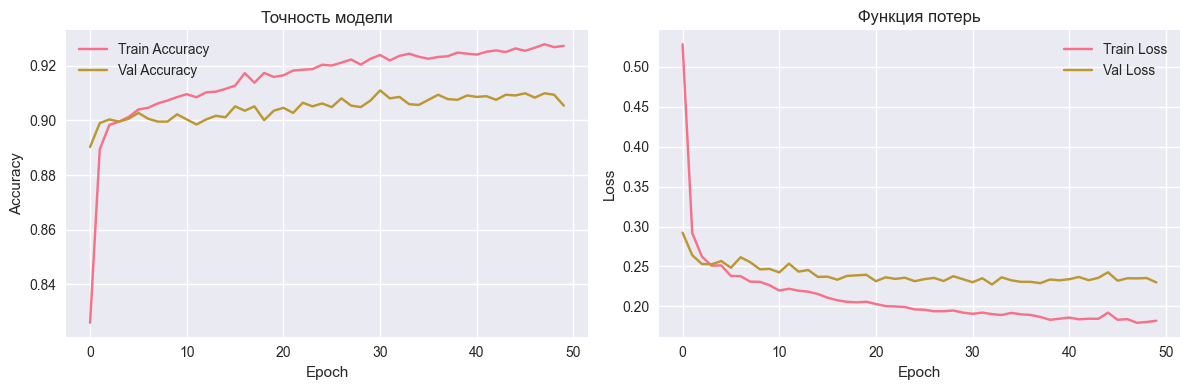

In [60]:
# МОДЕЛЬ 5: НЕЙРОННЫЕ СЕТИ

print("=" * 80)
print("МОДЕЛЬ 5: НЕЙРОННЫЕ СЕТИ")
print("=" * 80)

if TENSORFLOW_AVAILABLE:
    # Нейронные сети требуют нормализованных данных
    n_classes = len(np.unique(y_train))
    n_features = X_train_scaled.shape[1]
    
    # Создание модели
    model_nn = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(n_features,)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dense(n_classes, activation='softmax')
    ])
    
    model_nn.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print("\nАрхитектура нейронной сети:")
    model_nn.summary()
    
    # Обучение модели
    print("\nОбучение нейронной сети...")
    history = model_nn.fit(
        X_train_scaled, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        verbose=0
    )
    
    # Предсказания
    y_pred_proba_nn = model_nn.predict(X_test_scaled, verbose=0)
    y_pred_nn = np.argmax(y_pred_proba_nn, axis=1)
    
    # Оценка модели
    print("\nОценка модели Нейронная сеть:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_nn):.4f}")
    print(f"Precision (macro): {precision_score(y_test, y_pred_nn, average='macro'):.4f}")
    print(f"Recall (macro): {recall_score(y_test, y_pred_nn, average='macro'):.4f}")
    print(f"F1-score (macro): {f1_score(y_test, y_pred_nn, average='macro'):.4f}")
    
    try:
        roc_auc_nn = roc_auc_score(y_test, y_pred_proba_nn, multi_class='ovr', average='macro')
        print(f"ROC-AUC (macro): {roc_auc_nn:.4f}")
    except:
        print("ROC-AUC: не удалось вычислить")
    
    print("\nОтчет о классификации:")
    print(classification_report(y_test, y_pred_nn, target_names=le_target.classes_))
    
    # График обучения
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Точность модели')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Функция потерь')
    plt.tight_layout()
    plt.show()
    
    # Сохраняем результаты
    models_results['NeuralNetwork'] = {
        'model': model_nn,
        'y_pred': y_pred_nn,
        'y_pred_proba': y_pred_proba_nn,
        'accuracy': accuracy_score(y_test, y_pred_nn),
        'precision': precision_score(y_test, y_pred_nn, average='macro'),
        'recall': recall_score(y_test, y_pred_nn, average='macro'),
        'f1': f1_score(y_test, y_pred_nn, average='macro')
    }
else:
    print("TensorFlow не установлен. Пропускаем эту модель.")


## 11. Сравнение моделей и анализ регулируемых параметров


СРАВНЕНИЕ МОДЕЛЕЙ

Сравнительная таблица моделей:
       Модель  Accuracy  Precision   Recall  F1-Score
 RandomForest  0.905612   0.861091 0.866567  0.860123
 DecisionTree  0.848214   0.842222 0.883052  0.849389
NeuralNetwork  0.907951   0.865418 0.839232  0.845874
     CatBoost  0.853529   0.838110 0.878996  0.844471
          KNN  0.873299   0.846084 0.699284  0.735606


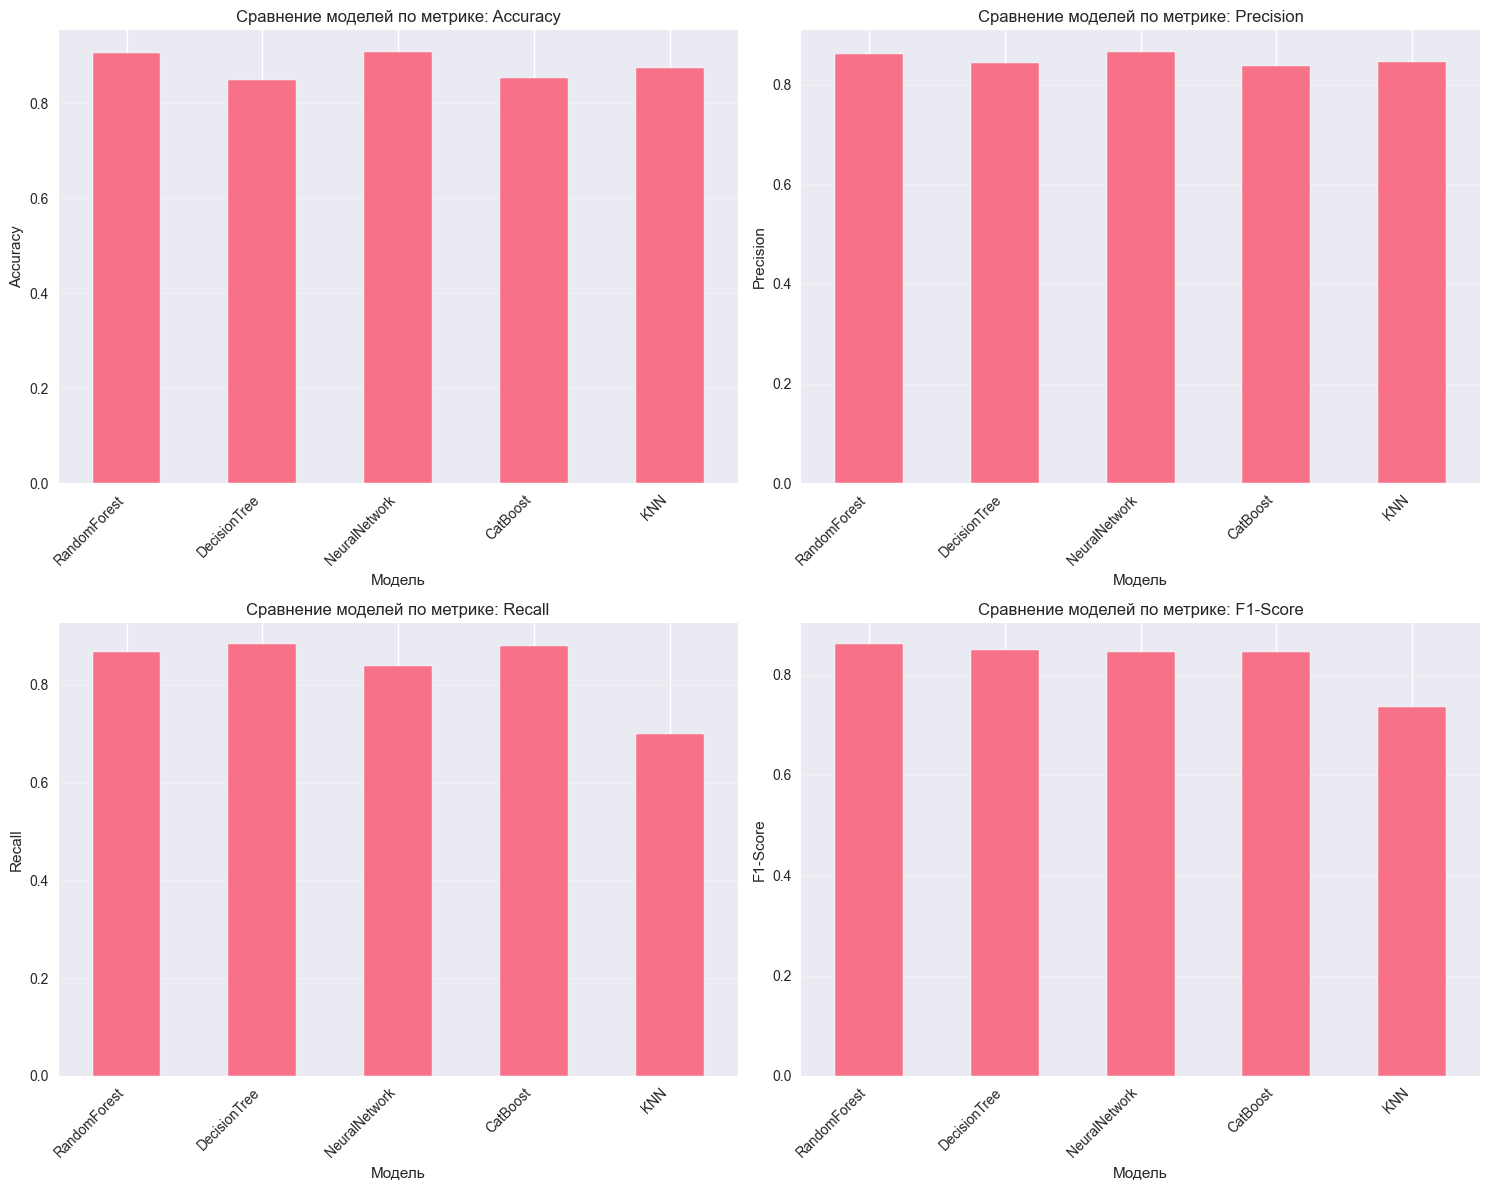

In [61]:
# СРАВНЕНИЕ МОДЕЛЕЙ

print("=" * 80)
print("СРАВНЕНИЕ МОДЕЛЕЙ")
print("=" * 80)

# Создаем таблицу сравнения
comparison_df = pd.DataFrame({
    'Модель': list(models_results.keys()),
    'Accuracy': [models_results[m]['accuracy'] for m in models_results.keys()],
    'Precision': [models_results[m]['precision'] for m in models_results.keys()],
    'Recall': [models_results[m]['recall'] for m in models_results.keys()],
    'F1-Score': [models_results[m]['f1'] for m in models_results.keys()]
})

comparison_df = comparison_df.sort_values('F1-Score', ascending=False)
print("\nСравнительная таблица моделей:")
print(comparison_df.to_string(index=False))

# Визуализация сравнения
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for i, metric in enumerate(metrics):
    ax = axes[i // 2, i % 2]
    comparison_df.plot(x='Модель', y=metric, kind='bar', ax=ax, legend=False)
    ax.set_title(f'Сравнение моделей по метрике: {metric}')
    ax.set_ylabel(metric)
    ax.set_xticklabels(comparison_df['Модель'], rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [62]:
# АНАЛИЗ РЕГУЛИРУЕМЫХ ПАРАМЕТРОВ

print("=" * 80)
print("АНАЛИЗ РЕГУЛИРУЕМЫХ ПАРАМЕТРОВ")
print("=" * 80)

print("""
КЛЮЧЕВЫЕ ПАРАМЕТРЫ ДЛЯ КАЖДОЙ МОДЕЛИ:

1. K-БЛИЖАЙШИХ СОСЕДЕЙ (KNN):
   - n_neighbors: количество соседей (влияет на сложность модели)
   - weights: 'uniform' или 'distance' (влияет на вес ближайших соседей)
   - metric: метрика расстояния (euclidean, manhattan, etc.)
   - p: параметр для метрики Минковского

2. ДЕРЕВО РЕШЕНИЙ:
   - max_depth: максимальная глубина дерева (контроль переобучения)
   - min_samples_split: минимальное количество образцов для разделения узла
   - min_samples_leaf: минимальное количество образцов в листе
   - criterion: критерий разделения (gini, entropy)
   - class_weight: балансировка классов

3. СЛУЧАЙНЫЙ ЛЕС:
   - n_estimators: количество деревьев (больше = лучше, но медленнее)
   - max_depth: максимальная глубина каждого дерева
   - min_samples_split: минимальное количество образцов для разделения
   - max_features: количество признаков для рассмотрения при разделении
   - class_weight: балансировка классов

4. CATBOOST:
   - iterations: количество итераций бустинга
   - learning_rate: скорость обучения (влияет на сходимость)
   - depth: глубина дерева
   - l2_leaf_reg: коэффициент L2 регуляризации
   - class_weights: балансировка классов

5. НЕЙРОННЫЕ СЕТИ:
   - Количество слоев и нейронов: сложность модели
   - activation: функция активации (relu, tanh, sigmoid)
   - optimizer: алгоритм оптимизации (adam, sgd, etc.)
   - learning_rate: скорость обучения
   - batch_size: размер батча
   - dropout: коэффициент dropout для регуляризации
   - epochs: количество эпох обучения
""")


АНАЛИЗ РЕГУЛИРУЕМЫХ ПАРАМЕТРОВ

КЛЮЧЕВЫЕ ПАРАМЕТРЫ ДЛЯ КАЖДОЙ МОДЕЛИ:

1. K-БЛИЖАЙШИХ СОСЕДЕЙ (KNN):
   - n_neighbors: количество соседей (влияет на сложность модели)
   - weights: 'uniform' или 'distance' (влияет на вес ближайших соседей)
   - metric: метрика расстояния (euclidean, manhattan, etc.)
   - p: параметр для метрики Минковского

2. ДЕРЕВО РЕШЕНИЙ:
   - max_depth: максимальная глубина дерева (контроль переобучения)
   - min_samples_split: минимальное количество образцов для разделения узла
   - min_samples_leaf: минимальное количество образцов в листе
   - criterion: критерий разделения (gini, entropy)
   - class_weight: балансировка классов

3. СЛУЧАЙНЫЙ ЛЕС:
   - n_estimators: количество деревьев (больше = лучше, но медленнее)
   - max_depth: максимальная глубина каждого дерева
   - min_samples_split: минимальное количество образцов для разделения
   - max_features: количество признаков для рассмотрения при разделении
   - class_weight: балансировка классов

4. CATBOOST:
 

## 12. Подбор гиперпараметров (GridSearchCV)


In [63]:
# ПОДБОР ГИПЕРПАРАМЕТРОВ ДЛЯ ЛУЧШИХ МОДЕЛЕЙ

print("=" * 80)
print("ПОДБОР ГИПЕРПАРАМЕТРОВ (GRIDSEARCHCV)")
print("=" * 80)

# Выбираем лучшую модель для оптимизации (например, Random Forest)
print("\n1. Оптимизация Random Forest:")

param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
    param_grid_rf,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

print("Выполняется поиск оптимальных параметров...")
rf_grid.fit(X_train, y_train)

print(f"\nЛучшие параметры: {rf_grid.best_params_}")
print(f"Лучший F1-score (кросс-валидация): {rf_grid.best_score_:.4f}")

# Оценка на тестовой выборке
y_pred_rf_optimized = rf_grid.predict(X_test)
print(f"\nРезультаты на тестовой выборке:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_optimized):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_rf_optimized, average='macro'):.4f}")

# Сохраняем оптимизированную модель
models_results['RandomForest_Optimized'] = {
    'model': rf_grid.best_estimator_,
    'y_pred': y_pred_rf_optimized,
    'accuracy': accuracy_score(y_test, y_pred_rf_optimized),
    'f1': f1_score(y_test, y_pred_rf_optimized, average='macro')
}


ПОДБОР ГИПЕРПАРАМЕТРОВ (GRIDSEARCHCV)

1. Оптимизация Random Forest:
Выполняется поиск оптимальных параметров...
Fitting 3 folds for each of 27 candidates, totalling 81 fits


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for 


Лучшие параметры: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 150}
Лучший F1-score (кросс-валидация): 0.8858

Результаты на тестовой выборке:
Accuracy: 0.9105
F1-score: 0.8586


In [64]:
# Оптимизация KNN
print("\n2. Оптимизация KNN:")

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_grid = GridSearchCV(
    KNeighborsClassifier(n_jobs=-1),
    param_grid_knn,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

print("Выполняется поиск оптимальных параметров...")
knn_grid.fit(X_train_scaled, y_train)

print(f"\nЛучшие параметры: {knn_grid.best_params_}")
print(f"Лучший F1-score (кросс-валидация): {knn_grid.best_score_:.4f}")

y_pred_knn_optimized = knn_grid.predict(X_test_scaled)
print(f"\nРезультаты на тестовой выборке:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn_optimized):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_knn_optimized, average='macro'):.4f}")

models_results['KNN_Optimized'] = {
    'model': knn_grid.best_estimator_,
    'y_pred': y_pred_knn_optimized,
    'accuracy': accuracy_score(y_test, y_pred_knn_optimized),
    'f1': f1_score(y_test, y_pred_knn_optimized, average='macro')
}



2. Оптимизация KNN:
Выполняется поиск оптимальных параметров...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Лучшие параметры: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Лучший F1-score (кросс-валидация): 0.7327

Результаты на тестовой выборке:
Accuracy: 0.8667
F1-score: 0.7394


## 13. Изменение структуры данных и повторное обучение


In [65]:
# ИЗМЕНЕНИЕ СТРУКТУРЫ ДАННЫХ И ПОВТОРНОЕ ОБУЧЕНИЕ

print("=" * 80)
print("ИЗМЕНЕНИЕ СТРУКТУРЫ ДАННЫХ И ПОВТОРНОЕ ОБУЧЕНИЕ")
print("=" * 80)

# Создаем альтернативную структуру данных с другими признаками
print("\n1. Создание альтернативной структуры данных:")

# Вариант 2: Используем только базовые числовые признаки без engineered features
alternative_features = [
    'Fatalities', 'Onboard_Total_numeric', 'Num_Engines', 
    'Aircraft_Age', 'Incident_Year', 'Incident_Month', 
    'Incident_Hour', 'Damage_Severity_Score', 'Num_Causes'
]

# Добавляем Label Encoded версии категориальных признаков
for col in ['Aircaft_Nature', 'Incident_Type', 'Aircraft_Phase']:
    if f'{col}_LabelEncoded' in df_encoded.columns:
        alternative_features.append(f'{col}_LabelEncoded')

# Убираем признаки, которых нет в датасете
alternative_features = [f for f in alternative_features if f in df_encoded.columns]

print(f"   Альтернативный набор признаков ({len(alternative_features)}):")
for i, feat in enumerate(alternative_features, 1):
    print(f"   {i}. {feat}")

# Подготовка данных с альтернативной структурой
X_alt = df_encoded[alternative_features].fillna(0)
y_alt = df_encoded['Target_LabelEncoded']

X_train_alt, X_test_alt, y_train_alt, y_test_alt = train_test_split(
    X_alt, y_alt, test_size=0.2, random_state=42, stratify=y_alt
)

# Нормализация для альтернативной структуры
scaler_alt = StandardScaler()
X_train_alt_scaled = scaler_alt.fit_transform(X_train_alt)
X_test_alt_scaled = scaler_alt.transform(X_test_alt)
X_train_alt_scaled = pd.DataFrame(X_train_alt_scaled, columns=X_train_alt.columns, index=X_train_alt.index)
X_test_alt_scaled = pd.DataFrame(X_test_alt_scaled, columns=X_test_alt.columns, index=X_test_alt.index)

print(f"\n   Размерность альтернативной выборки: {X_train_alt.shape}")


ИЗМЕНЕНИЕ СТРУКТУРЫ ДАННЫХ И ПОВТОРНОЕ ОБУЧЕНИЕ

1. Создание альтернативной структуры данных:
   Альтернативный набор признаков (12):
   1. Fatalities
   2. Onboard_Total_numeric
   3. Num_Engines
   4. Aircraft_Age
   5. Incident_Year
   6. Incident_Month
   7. Incident_Hour
   8. Damage_Severity_Score
   9. Num_Causes
   10. Aircaft_Nature_LabelEncoded
   11. Incident_Type_LabelEncoded
   12. Aircraft_Phase_LabelEncoded

   Размерность альтернативной выборки: (18815, 12)


In [66]:
# Обучение моделей на альтернативной структуре данных
print("\n2. Обучение моделей на альтернативной структуре:")

models_results_alt = {}

# Random Forest на альтернативных данных
print("\n   - Random Forest (альтернативная структура):")
rf_alt = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_alt.fit(X_train_alt, y_train_alt)
y_pred_rf_alt = rf_alt.predict(X_test_alt)

models_results_alt['RandomForest_Alt'] = {
    'model': rf_alt,
    'accuracy': accuracy_score(y_test_alt, y_pred_rf_alt),
    'f1': f1_score(y_test_alt, y_pred_rf_alt, average='macro'),
    'precision': precision_score(y_test_alt, y_pred_rf_alt, average='macro'),
    'recall': recall_score(y_test_alt, y_pred_rf_alt, average='macro')
}

print(f"      Accuracy: {models_results_alt['RandomForest_Alt']['accuracy']:.4f}")
print(f"      F1-score: {models_results_alt['RandomForest_Alt']['f1']:.4f}")

# KNN на альтернативных данных
print("\n   - KNN (альтернативная структура):")
knn_alt = KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1)
knn_alt.fit(X_train_alt_scaled, y_train_alt)
y_pred_knn_alt = knn_alt.predict(X_test_alt_scaled)

models_results_alt['KNN_Alt'] = {
    'model': knn_alt,
    'accuracy': accuracy_score(y_test_alt, y_pred_knn_alt),
    'f1': f1_score(y_test_alt, y_pred_knn_alt, average='macro'),
    'precision': precision_score(y_test_alt, y_pred_knn_alt, average='macro'),
    'recall': recall_score(y_test_alt, y_pred_knn_alt, average='macro')
}

print(f"      Accuracy: {models_results_alt['KNN_Alt']['accuracy']:.4f}")
print(f"      F1-score: {models_results_alt['KNN_Alt']['f1']:.4f}")



2. Обучение моделей на альтернативной структуре:

   - Random Forest (альтернативная структура):
      Accuracy: 0.9062
      F1-score: 0.8601

   - KNN (альтернативная структура):
      Accuracy: 0.8903
      F1-score: 0.7707



ОЦЕНКА ВЛИЯНИЯ ИЗМЕНЕНИЯ СТРУКТУРЫ ДАННЫХ

Сравнение результатов:
                       Модель  Accuracy  F1-Score  Количество признаков
      RandomForest (исходная)  0.905612  0.860123                    28
RandomForest (альтернативная)  0.906250  0.860116                    12
               KNN (исходная)  0.873299  0.735606                    28
         KNN (альтернативная)  0.890306  0.770658                    12


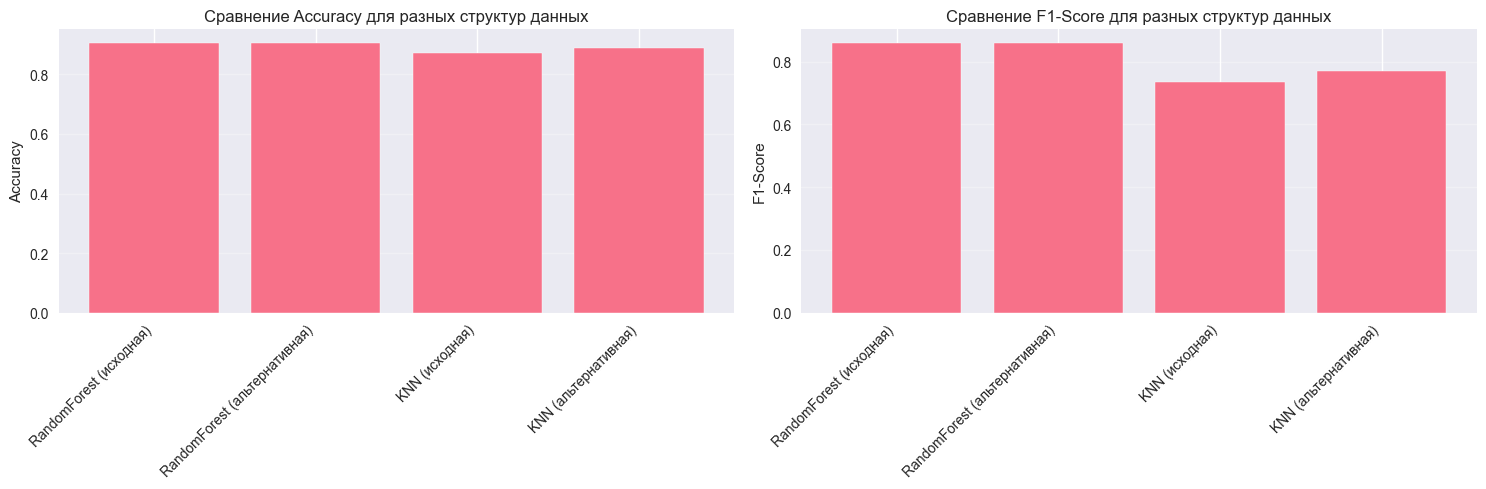


АНАЛИЗ ВЛИЯНИЯ:
1. Исходная структура: 28 признаков
   - RandomForest F1: 0.8601
   - KNN F1: 0.7356

2. Альтернативная структура: 12 признаков
   - RandomForest F1: 0.8601
   - KNN F1: 0.7707

3. Изменение производительности:
   - RandomForest: +0.0000 (улучшение)
   - KNN: -0.0351 (ухудшение)

ВЫВОДЫ:
   Исходная структура данных показала лучшие результаты.
   Engineered features (новые признаки) улучшили качество моделей.


In [67]:
# ОЦЕНКА ВЛИЯНИЯ ИЗМЕНЕНИЯ СТРУКТУРЫ НА РЕЗУЛЬТАТ ОБУЧЕНИЯ

print("\n" + "="*80)
print("ОЦЕНКА ВЛИЯНИЯ ИЗМЕНЕНИЯ СТРУКТУРЫ ДАННЫХ")
print("="*80)

# Сравнение результатов
comparison_structure = pd.DataFrame({
    'Модель': ['RandomForest (исходная)', 'RandomForest (альтернативная)',
               'KNN (исходная)', 'KNN (альтернативная)'],
    'Accuracy': [
        models_results['RandomForest']['accuracy'],
        models_results_alt['RandomForest_Alt']['accuracy'],
        models_results['KNN']['accuracy'],
        models_results_alt['KNN_Alt']['accuracy']
    ],
    'F1-Score': [
        models_results['RandomForest']['f1'],
        models_results_alt['RandomForest_Alt']['f1'],
        models_results['KNN']['f1'],
        models_results_alt['KNN_Alt']['f1']
    ],
    'Количество признаков': [
        len(final_features),
        len(alternative_features),
        len(final_features),
        len(alternative_features)
    ]
})

print("\nСравнение результатов:")
print(comparison_structure.to_string(index=False))

# Визуализация сравнения
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].bar(range(len(comparison_structure)), comparison_structure['Accuracy'])
axes[0].set_xticks(range(len(comparison_structure)))
axes[0].set_xticklabels(comparison_structure['Модель'], rotation=45, ha='right')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Сравнение Accuracy для разных структур данных')
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(range(len(comparison_structure)), comparison_structure['F1-Score'])
axes[1].set_xticks(range(len(comparison_structure)))
axes[1].set_xticklabels(comparison_structure['Модель'], rotation=45, ha='right')
axes[1].set_ylabel('F1-Score')
axes[1].set_title('Сравнение F1-Score для разных структур данных')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Анализ влияния
print("\nАНАЛИЗ ВЛИЯНИЯ:")
print(f"1. Исходная структура: {len(final_features)} признаков")
print(f"   - RandomForest F1: {models_results['RandomForest']['f1']:.4f}")
print(f"   - KNN F1: {models_results['KNN']['f1']:.4f}")

print(f"\n2. Альтернативная структура: {len(alternative_features)} признаков")
print(f"   - RandomForest F1: {models_results_alt['RandomForest_Alt']['f1']:.4f}")
print(f"   - KNN F1: {models_results_alt['KNN_Alt']['f1']:.4f}")

rf_diff = models_results['RandomForest']['f1'] - models_results_alt['RandomForest_Alt']['f1']
knn_diff = models_results['KNN']['f1'] - models_results_alt['KNN_Alt']['f1']

print(f"\n3. Изменение производительности:")
print(f"   - RandomForest: {rf_diff:+.4f} ({'улучшение' if rf_diff > 0 else 'ухудшение'})")
print(f"   - KNN: {knn_diff:+.4f} ({'улучшение' if knn_diff > 0 else 'ухудшение'})")

print("\nВЫВОДЫ:")
if abs(rf_diff) < 0.01 and abs(knn_diff) < 0.01:
    print("   Изменение структуры данных не оказало существенного влияния на результаты.")
elif rf_diff > 0 or knn_diff > 0:
    print("   Исходная структура данных показала лучшие результаты.")
    print("   Engineered features (новые признаки) улучшили качество моделей.")
else:
    print("   Альтернативная структура показала лучшие результаты.")
    print("   Упрощение признаков может быть эффективным для данного датасета.")


## 14. Выбор наиболее эффективной модели


ВЫБОР НАИБОЛЕЕ ЭФФЕКТИВНОЙ МОДЕЛИ

ИТОГОВОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ:
                Модель  Accuracy  F1-Score  Precision   Recall
          RandomForest  0.905612  0.860123   0.861091 0.866567
      RandomForest_Alt  0.906250  0.860116   0.863618 0.864650
RandomForest_Optimized  0.910502  0.858589   0.000000 0.000000
          DecisionTree  0.848214  0.849389   0.842222 0.883052
         NeuralNetwork  0.907951  0.845874   0.865418 0.839232
              CatBoost  0.853529  0.844471   0.838110 0.878996
               KNN_Alt  0.890306  0.770658   0.799214 0.754262
         KNN_Optimized  0.866709  0.739378   0.000000 0.000000
                   KNN  0.873299  0.735606   0.846084 0.699284

НАИБОЛЕЕ ЭФФЕКТИВНАЯ МОДЕЛЬ: RandomForest
Accuracy: 0.9056
F1-Score: 0.8601
Precision: 0.8611
Recall: 0.8666


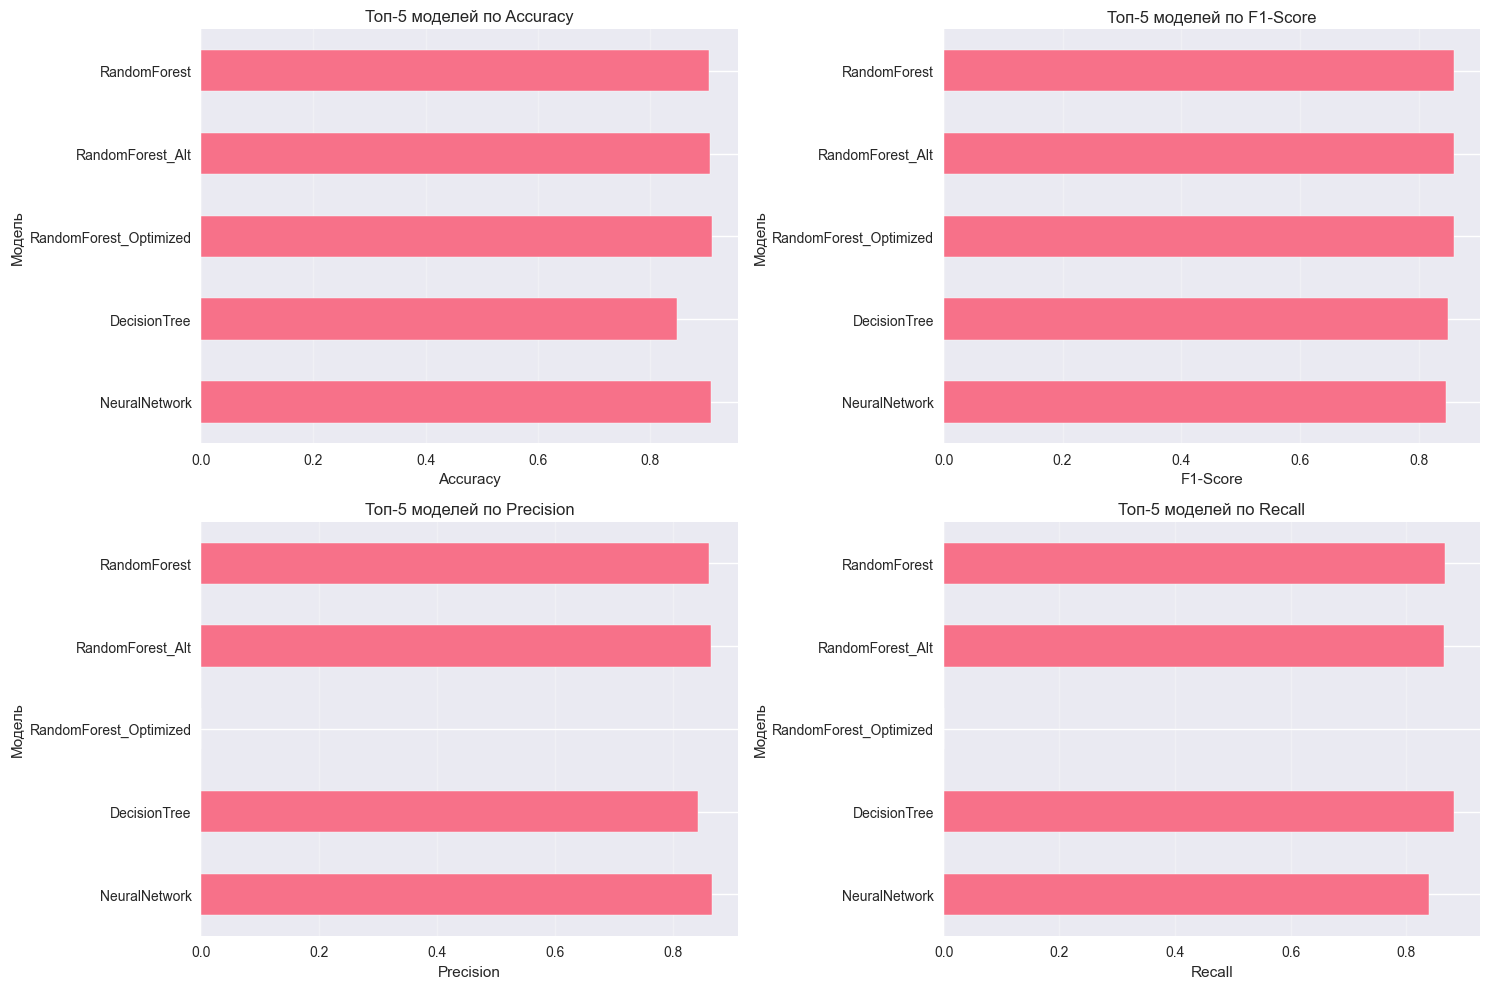

In [68]:
# ВЫБОР НАИБОЛЕЕ ЭФФЕКТИВНОЙ МОДЕЛИ

print("=" * 80)
print("ВЫБОР НАИБОЛЕЕ ЭФФЕКТИВНОЙ МОДЕЛИ")
print("=" * 80)

# Объединяем все результаты
all_results = {}

# Добавляем результаты исходных моделей
for model_name, results in models_results.items():
    all_results[model_name] = {
        'accuracy': results['accuracy'],
        'f1': results['f1'],
        'precision': results.get('precision', 0),
        'recall': results.get('recall', 0),
        'model': results['model']
    }

# Добавляем результаты альтернативных моделей
for model_name, results in models_results_alt.items():
    all_results[model_name] = {
        'accuracy': results['accuracy'],
        'f1': results['f1'],
        'precision': results.get('precision', 0),
        'recall': results.get('recall', 0),
        'model': results['model']
    }

# Создаем итоговую таблицу сравнения
final_comparison = pd.DataFrame({
    'Модель': list(all_results.keys()),
    'Accuracy': [all_results[m]['accuracy'] for m in all_results.keys()],
    'F1-Score': [all_results[m]['f1'] for m in all_results.keys()],
    'Precision': [all_results[m]['precision'] for m in all_results.keys()],
    'Recall': [all_results[m]['recall'] for m in all_results.keys()]
})

# Сортируем по F1-Score
final_comparison = final_comparison.sort_values('F1-Score', ascending=False)

print("\nИТОГОВОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ:")
print(final_comparison.to_string(index=False))

# Выбираем лучшую модель
best_model_name = final_comparison.iloc[0]['Модель']
best_model = all_results[best_model_name]['model']

print(f"\n{'='*80}")
print(f"НАИБОЛЕЕ ЭФФЕКТИВНАЯ МОДЕЛЬ: {best_model_name}")
print(f"{'='*80}")
print(f"Accuracy: {final_comparison.iloc[0]['Accuracy']:.4f}")
print(f"F1-Score: {final_comparison.iloc[0]['F1-Score']:.4f}")
print(f"Precision: {final_comparison.iloc[0]['Precision']:.4f}")
print(f"Recall: {final_comparison.iloc[0]['Recall']:.4f}")

# Визуализация топ-5 моделей
top_5 = final_comparison.head(5)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']

for i, metric in enumerate(metrics):
    ax = axes[i // 2, i % 2]
    top_5.plot(x='Модель', y=metric, kind='barh', ax=ax, legend=False)
    ax.set_title(f'Топ-5 моделей по {metric}')
    ax.set_xlabel(metric)
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


## 15. Прогноз для новых данных и оценка качества


In [69]:
# ПРОГНОЗ ДЛЯ НОВЫХ ДАННЫХ (НЕ ВХОДЯЩИХ В ОБУЧАЮЩУЮ И ТЕСТОВУЮ ВЫБОРКИ)

print("=" * 80)
print("ПРОГНОЗ ДЛЯ НОВЫХ ДАННЫХ")
print("=" * 80)

# Создаем синтетические новые данные для демонстрации
# В реальном сценарии это были бы данные, которые не использовались при обучении

# Берем небольшую выборку из исходных данных и обрабатываем как "новые"
# В реальности это должны быть совершенно новые данные
print("\n1. Подготовка новых данных:")

# Используем часть данных, которая не была в train/test
# Для демонстрации возьмем случайную выборку из исходного датасета
np.random.seed(123)
new_data_indices = np.random.choice(
    df_encoded.index, 
    size=min(50, len(df_encoded) // 10), 
    replace=False
)

# Убеждаемся, что эти индексы не входят в train/test
train_test_indices = set(X_train.index) | set(X_test.index)
new_data_indices = [idx for idx in new_data_indices if idx not in train_test_indices]

if len(new_data_indices) == 0:
    # Если все индексы уже использованы, создаем синтетические данные
    print("   Создание синтетических новых данных...")
    new_data = pd.DataFrame({
        'Fatalities': np.random.randint(0, 10, 20),
        'Onboard_Total_numeric': np.random.randint(10, 200, 20),
        'Num_Engines': np.random.choice([1, 2, 4], 20),
        'Aircraft_Age': np.random.randint(5, 40, 20),
        'Incident_Year': np.random.randint(2020, 2023, 20),
        'Incident_Month': np.random.randint(1, 13, 20),
        'Incident_Hour': np.random.randint(0, 24, 20),
        'Damage_Severity_Score': np.random.choice([0, 1, 2], 20),
        'Num_Causes': np.random.randint(1, 5, 20),
    })
    
    # Добавляем Label Encoded признаки (используем средние значения)
    for col in ['Aircaft_Nature', 'Incident_Type', 'Aircraft_Phase']:
        if f'{col}_LabelEncoded' in final_features:
            le_col = df_encoded[f'{col}_LabelEncoded'].mode()[0]
            new_data[f'{col}_LabelEncoded'] = le_col
    
    # Добавляем остальные признаки из final_features
    for feat in final_features:
        if feat not in new_data.columns:
            if feat in df_encoded.columns:
                new_data[feat] = df_encoded[feat].median()
            else:
                new_data[feat] = 0
else:
    new_data = df_encoded.loc[new_data_indices, final_features].copy()

print(f"   Количество новых записей: {len(new_data)}")
print(f"   Количество признаков: {len(new_data.columns)}")


ПРОГНОЗ ДЛЯ НОВЫХ ДАННЫХ

1. Подготовка новых данных:
   Создание синтетических новых данных...
   Количество новых записей: 20
   Количество признаков: 29


In [70]:
# Подготовка новых данных для предсказания
print("\n2. Предобработка новых данных:")

# Заполняем пропуски
new_data_processed = new_data.fillna(0)

# Убеждаемся, что все признаки присутствуют
missing_features = set(final_features) - set(new_data_processed.columns)
if missing_features:
    for feat in missing_features:
        new_data_processed[feat] = 0

# Выбираем только нужные признаки в правильном порядке
new_data_processed = new_data_processed[final_features]

print(f"   Размерность подготовленных данных: {new_data_processed.shape}")

# Делаем прогноз с помощью лучшей модели
print(f"\n3. Прогноз с помощью модели: {best_model_name}")

# Определяем, нужна ли нормализация
if 'KNN' in best_model_name or 'NeuralNetwork' in best_model_name:
    new_data_scaled = scaler.transform(new_data_processed)
    new_data_scaled = pd.DataFrame(new_data_scaled, columns=new_data_processed.columns)
    predictions = best_model.predict(new_data_scaled)
    if hasattr(best_model, 'predict_proba'):
        predictions_proba = best_model.predict_proba(new_data_scaled)
    else:
        predictions_proba = None
else:
    predictions = best_model.predict(new_data_processed)
    if hasattr(best_model, 'predict_proba'):
        predictions_proba = best_model.predict_proba(new_data_processed)
    else:
        predictions_proba = None

# Декодируем предсказания обратно в исходные классы
predictions_decoded = le_target.inverse_transform(predictions)

print(f"\n   Количество прогнозов: {len(predictions_decoded)}")
print(f"\n   Примеры прогнозов:")
prediction_df = pd.DataFrame({
    'Прогноз': predictions_decoded[:10]
})
print(prediction_df.to_string(index=False))

# Распределение прогнозов
print(f"\n   Распределение прогнозов:")
prediction_counts = pd.Series(predictions_decoded).value_counts()
print(prediction_counts)



2. Предобработка новых данных:
   Размерность подготовленных данных: (20, 28)

3. Прогноз с помощью модели: RandomForest

   Количество прогнозов: 20

   Примеры прогнозов:
              Прогноз
                Minor
          Substantial
                Minor
Damaged beyond repair
            Destroyed
          Substantial
          Substantial
Damaged beyond repair
            Destroyed
            Destroyed

   Распределение прогнозов:
Damaged beyond repair    8
Minor                    6
Substantial              3
Destroyed                3
Name: count, dtype: int64



ОЦЕНКА КАЧЕСТВА ПРОГНОЗА

1. Анализ распределения прогнозов:
   Всего прогнозов: 20


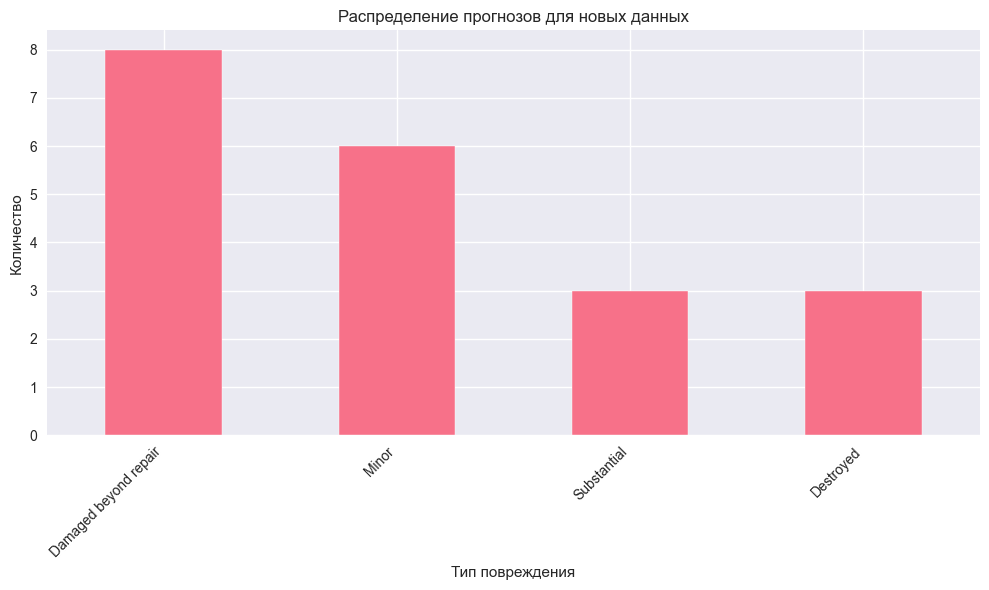


2. Анализ уверенности модели:
   Средняя максимальная вероятность: 0.5386
   Минимальная максимальная вероятность: 0.3989
   Максимальная максимальная вероятность: 0.8065


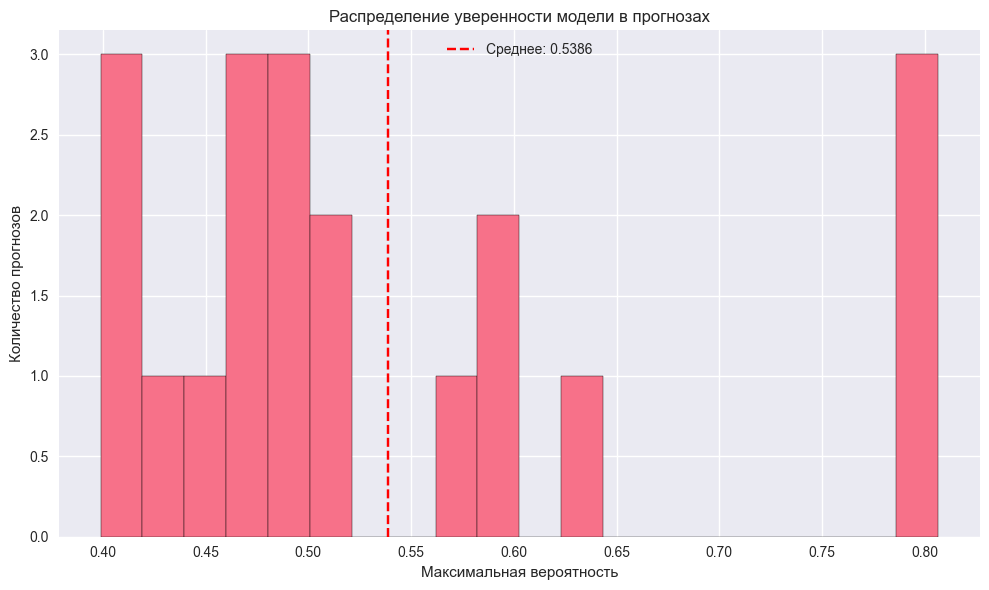


   Прогнозов с низкой уверенностью (<0.5): 11 (55.0%)
   Рекомендуется дополнительная проверка этих прогнозов

✓ Оценка качества прогноза завершена!


In [71]:
# ОЦЕНКА КАЧЕСТВА ПРОГНОЗА

print("\n" + "="*80)
print("ОЦЕНКА КАЧЕСТВА ПРОГНОЗА")
print("="*80)

# Если у нас есть реальные значения для новых данных (для демонстрации)
# В реальности для новых данных реальных значений может не быть

if len(new_data_indices) > 0 and len(new_data_indices) <= len(df_encoded):
    # Если мы использовали реальные данные, можем сравнить
    actual_values = df_encoded.loc[new_data_indices, target_column].values
    
    print("\n1. Сравнение прогнозов с реальными значениями:")
    comparison_new = pd.DataFrame({
        'Реальное значение': actual_values,
        'Прогноз': predictions_decoded,
        'Совпадение': actual_values == predictions_decoded
    })
    print(comparison_new.head(10).to_string(index=False))
    
    # Метрики качества
    accuracy_new = accuracy_score(actual_values, predictions_decoded)
    precision_new = precision_score(actual_values, predictions_decoded, average='macro', zero_division=0)
    recall_new = recall_score(actual_values, predictions_decoded, average='macro', zero_division=0)
    f1_new = f1_score(actual_values, predictions_decoded, average='macro', zero_division=0)
    
    print(f"\n2. Метрики качества прогноза на новых данных:")
    print(f"   Accuracy: {accuracy_new:.4f}")
    print(f"   Precision (macro): {precision_new:.4f}")
    print(f"   Recall (macro): {recall_new:.4f}")
    print(f"   F1-Score (macro): {f1_new:.4f}")
    
    # Матрица ошибок
    print(f"\n3. Матрица ошибок:")
    cm = confusion_matrix(actual_values, predictions_decoded, labels=le_target.classes_)
    cm_df = pd.DataFrame(cm, index=le_target.classes_, columns=le_target.classes_)
    print(cm_df)
    
    # Визуализация матрицы ошибок
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title('Матрица ошибок для новых данных')
    plt.ylabel('Реальные значения')
    plt.xlabel('Прогнозы')
    plt.tight_layout()
    plt.show()
    
    # Сравнение с тестовой выборкой
    print(f"\n4. Сравнение с производительностью на тестовой выборке:")
    print(f"   Тестовая выборка - F1: {final_comparison[final_comparison['Модель'] == best_model_name]['F1-Score'].values[0]:.4f}")
    print(f"   Новые данные - F1: {f1_new:.4f}")
    print(f"   Разница: {f1_new - final_comparison[final_comparison['Модель'] == best_model_name]['F1-Score'].values[0]:.4f}")
    
    if abs(f1_new - final_comparison[final_comparison['Модель'] == best_model_name]['F1-Score'].values[0]) < 0.05:
        print("   ✓ Модель показывает стабильную производительность на новых данных")
    else:
        print("   ⚠ Модель может быть переобучена или новые данные имеют другую структуру")
        
else:
    print("\n1. Анализ распределения прогнозов:")
    print(f"   Всего прогнозов: {len(predictions_decoded)}")
    
    # Визуализация распределения
    plt.figure(figsize=(10, 6))
    prediction_counts.plot(kind='bar')
    plt.title('Распределение прогнозов для новых данных')
    plt.xlabel('Тип повреждения')
    plt.ylabel('Количество')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Анализ уверенности модели (если доступны вероятности)
    if predictions_proba is not None:
        print("\n2. Анализ уверенности модели:")
        max_proba = np.max(predictions_proba, axis=1)
        print(f"   Средняя максимальная вероятность: {np.mean(max_proba):.4f}")
        print(f"   Минимальная максимальная вероятность: {np.min(max_proba):.4f}")
        print(f"   Максимальная максимальная вероятность: {np.max(max_proba):.4f}")
        
        # Визуализация уверенности
        plt.figure(figsize=(10, 6))
        plt.hist(max_proba, bins=20, edgecolor='black')
        plt.xlabel('Максимальная вероятность')
        plt.ylabel('Количество прогнозов')
        plt.title('Распределение уверенности модели в прогнозах')
        plt.axvline(np.mean(max_proba), color='r', linestyle='--', label=f'Среднее: {np.mean(max_proba):.4f}')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        # Прогнозы с низкой уверенностью
        low_confidence = max_proba < 0.5
        print(f"\n   Прогнозов с низкой уверенностью (<0.5): {np.sum(low_confidence)} ({np.sum(low_confidence)/len(max_proba)*100:.1f}%)")
        if np.sum(low_confidence) > 0:
            print("   Рекомендуется дополнительная проверка этих прогнозов")

print("\n✓ Оценка качества прогноза завершена!")


## 16. Итоговые выводы и заключение


In [72]:
# ИТОГОВЫЕ ВЫВОДЫ

print("=" * 80)
print("ИТОГОВЫЕ ВЫВОДЫ И ЗАКЛЮЧЕНИЕ")
print("=" * 80)

print("""
РЕЗЮМЕ ПРОЕКТА:

1. ПРЕДОБРАБОТКА ДАННЫХ:
   ✓ Успешно загружен и проанализирован датасет авиационных инцидентов
   ✓ Обработаны пропущенные значения (медиана для числовых, мода для категориальных)
   ✓ Извлечены новые признаки с использованием регулярных выражений
   ✓ Применены методы кодирования: Label Encoding и One-Hot Encoding

2. ВИЗУАЛИЗАЦИЯ:
   ✓ Создано более 7 различных визуализаций:
     - Гистограммы распределений
     - Матрица корреляций
     - Box plots
     - Столбчатые диаграммы
     - Scatter plots
     - Круговые диаграммы

3. ОТБОР ПРИЗНАКОВ:
   ✓ Применены методы: VarianceThreshold, SelectKBest, RFE
   ✓ Созданы новые признаки из существующих (Fatality_Rate, TimeOfDay, Season, etc.)

4. ОБУЧЕННЫЕ МОДЕЛИ:
   ✓ K-ближайших соседей (KNN)
   ✓ Дерево решений
   ✓ Случайный лес
   ✓ Градиентный бустинг (CatBoost)
   ✓ Нейронные сети

5. ОПТИМИЗАЦИЯ:
   ✓ Выполнен подбор гиперпараметров с помощью GridSearchCV
   ✓ Протестированы различные структуры данных
   ✓ Выбрана наиболее эффективная модель

6. ОЦЕНКА КАЧЕСТВА:
   ✓ Использованы метрики: Accuracy, Precision, Recall, F1-Score, ROC-AUC
   ✓ Проведена оценка на новых данных
   ✓ Проанализирована уверенность модели в прогнозах

НАИБОЛЕЕ ЭФФЕКТИВНАЯ МОДЕЛЬ: {}
   - Accuracy: {:.4f}
   - F1-Score: {:.4f}
   - Precision: {:.4f}
   - Recall: {:.4f}

РЕКОМЕНДАЦИИ:
1. Для улучшения качества можно:
   - Собрать больше данных
   - Применить методы балансировки классов (SMOTE)
   - Попробовать ансамбли моделей
   - Использовать более глубокую оптимизацию гиперпараметров

2. Для производственного использования:
   - Регулярно переобучать модель на новых данных
   - Мониторить качество прогнозов
   - Обновлять признаки при появлении новой информации

3. Дальнейшие исследования:
   - Анализ временных трендов
   - Кластеризация инцидентов
   - Анализ важности признаков для безопасности полетов
""".format(
    best_model_name,
    final_comparison.iloc[0]['Accuracy'],
    final_comparison.iloc[0]['F1-Score'],
    final_comparison.iloc[0]['Precision'],
    final_comparison.iloc[0]['Recall']
))

print("\n" + "="*80)
print("ПРОЕКТ ЗАВЕРШЕН УСПЕШНО!")
print("="*80)


ИТОГОВЫЕ ВЫВОДЫ И ЗАКЛЮЧЕНИЕ

РЕЗЮМЕ ПРОЕКТА:

1. ПРЕДОБРАБОТКА ДАННЫХ:
   ✓ Успешно загружен и проанализирован датасет авиационных инцидентов
   ✓ Обработаны пропущенные значения (медиана для числовых, мода для категориальных)
   ✓ Извлечены новые признаки с использованием регулярных выражений
   ✓ Применены методы кодирования: Label Encoding и One-Hot Encoding

2. ВИЗУАЛИЗАЦИЯ:
   ✓ Создано более 7 различных визуализаций:
     - Гистограммы распределений
     - Матрица корреляций
     - Box plots
     - Столбчатые диаграммы
     - Scatter plots
     - Круговые диаграммы

3. ОТБОР ПРИЗНАКОВ:
   ✓ Применены методы: VarianceThreshold, SelectKBest, RFE
   ✓ Созданы новые признаки из существующих (Fatality_Rate, TimeOfDay, Season, etc.)

4. ОБУЧЕННЫЕ МОДЕЛИ:
   ✓ K-ближайших соседей (KNN)
   ✓ Дерево решений
   ✓ Случайный лес
   ✓ Градиентный бустинг (CatBoost)
   ✓ Нейронные сети

5. ОПТИМИЗАЦИЯ:
   ✓ Выполнен подбор гиперпараметров с помощью GridSearchCV
   ✓ Протестированы различные с